# Проект: Прогнозирование количества заказов такси на следующий час

## Данные

В наличии были следующие данные о комментариях в интернет-магазине:

- datetime 
- num_orders - количество заказов

## Задача

Разработка системы предсказания объема заказа.

## Используемые библиотеки

pandas, os, matplotlib, sklearn, lightgbm, statsmodels, scipy

## Подготовка

### Обзор данных

In [1]:
import pandas as pd
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor

from scipy import stats
from scipy.special import boxcox


import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
path = '/datasets/taxi.csv'
if not os.path.exists(path):
    path = 'DataFrames/taxi.csv'
    
data = pd.read_csv(path, index_col=[0], parse_dates=[0])

In [335]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [336]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Предобработка

In [337]:
data.index.duplicated().sum() # Проверка на явные дубликаты

0

In [338]:
# Подсчет пропусков в процентах
pd.DataFrame(data.isna().mean()*100,).style.background_gradient('coolwarm')

In [339]:
data.sort_index(inplace=True) # Ресемплирование
data = data.resample('1H').sum()

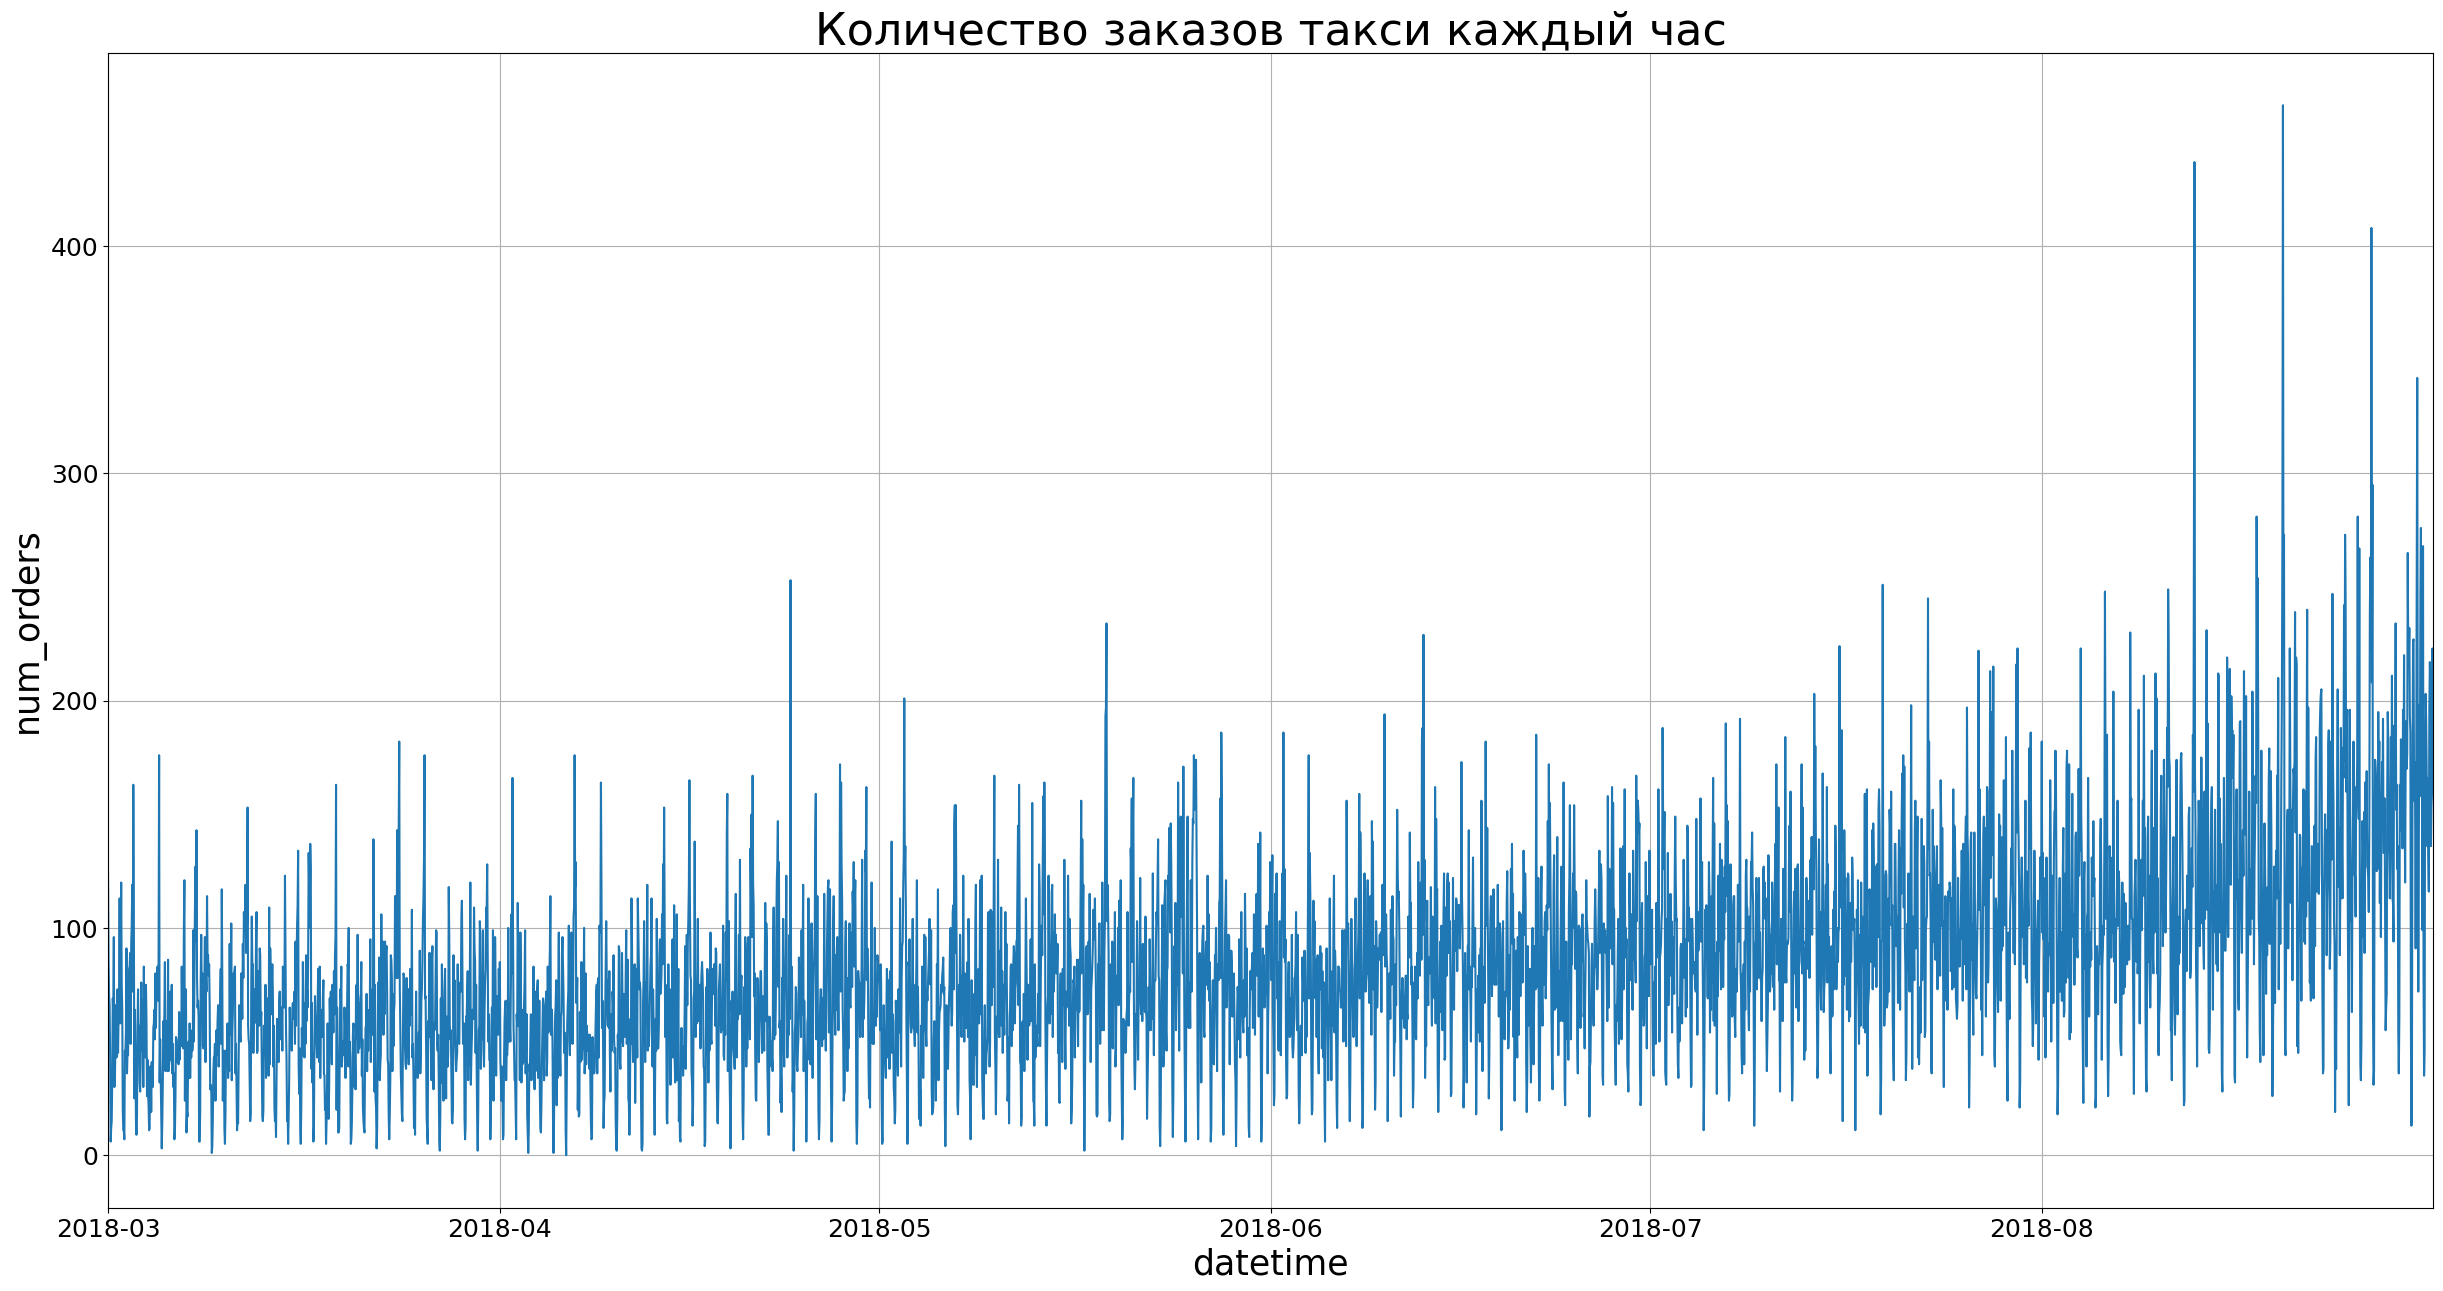

In [340]:
plt.figure(figsize=(30, 15))
plt.plot(data)

plt.xlabel("datetime", fontsize=25)
plt.ylabel("num_orders", fontsize=25)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Количество заказов такси каждый час', fontsize=32)
plt.xlim(data.index[0],data.index[-1])

plt.show()

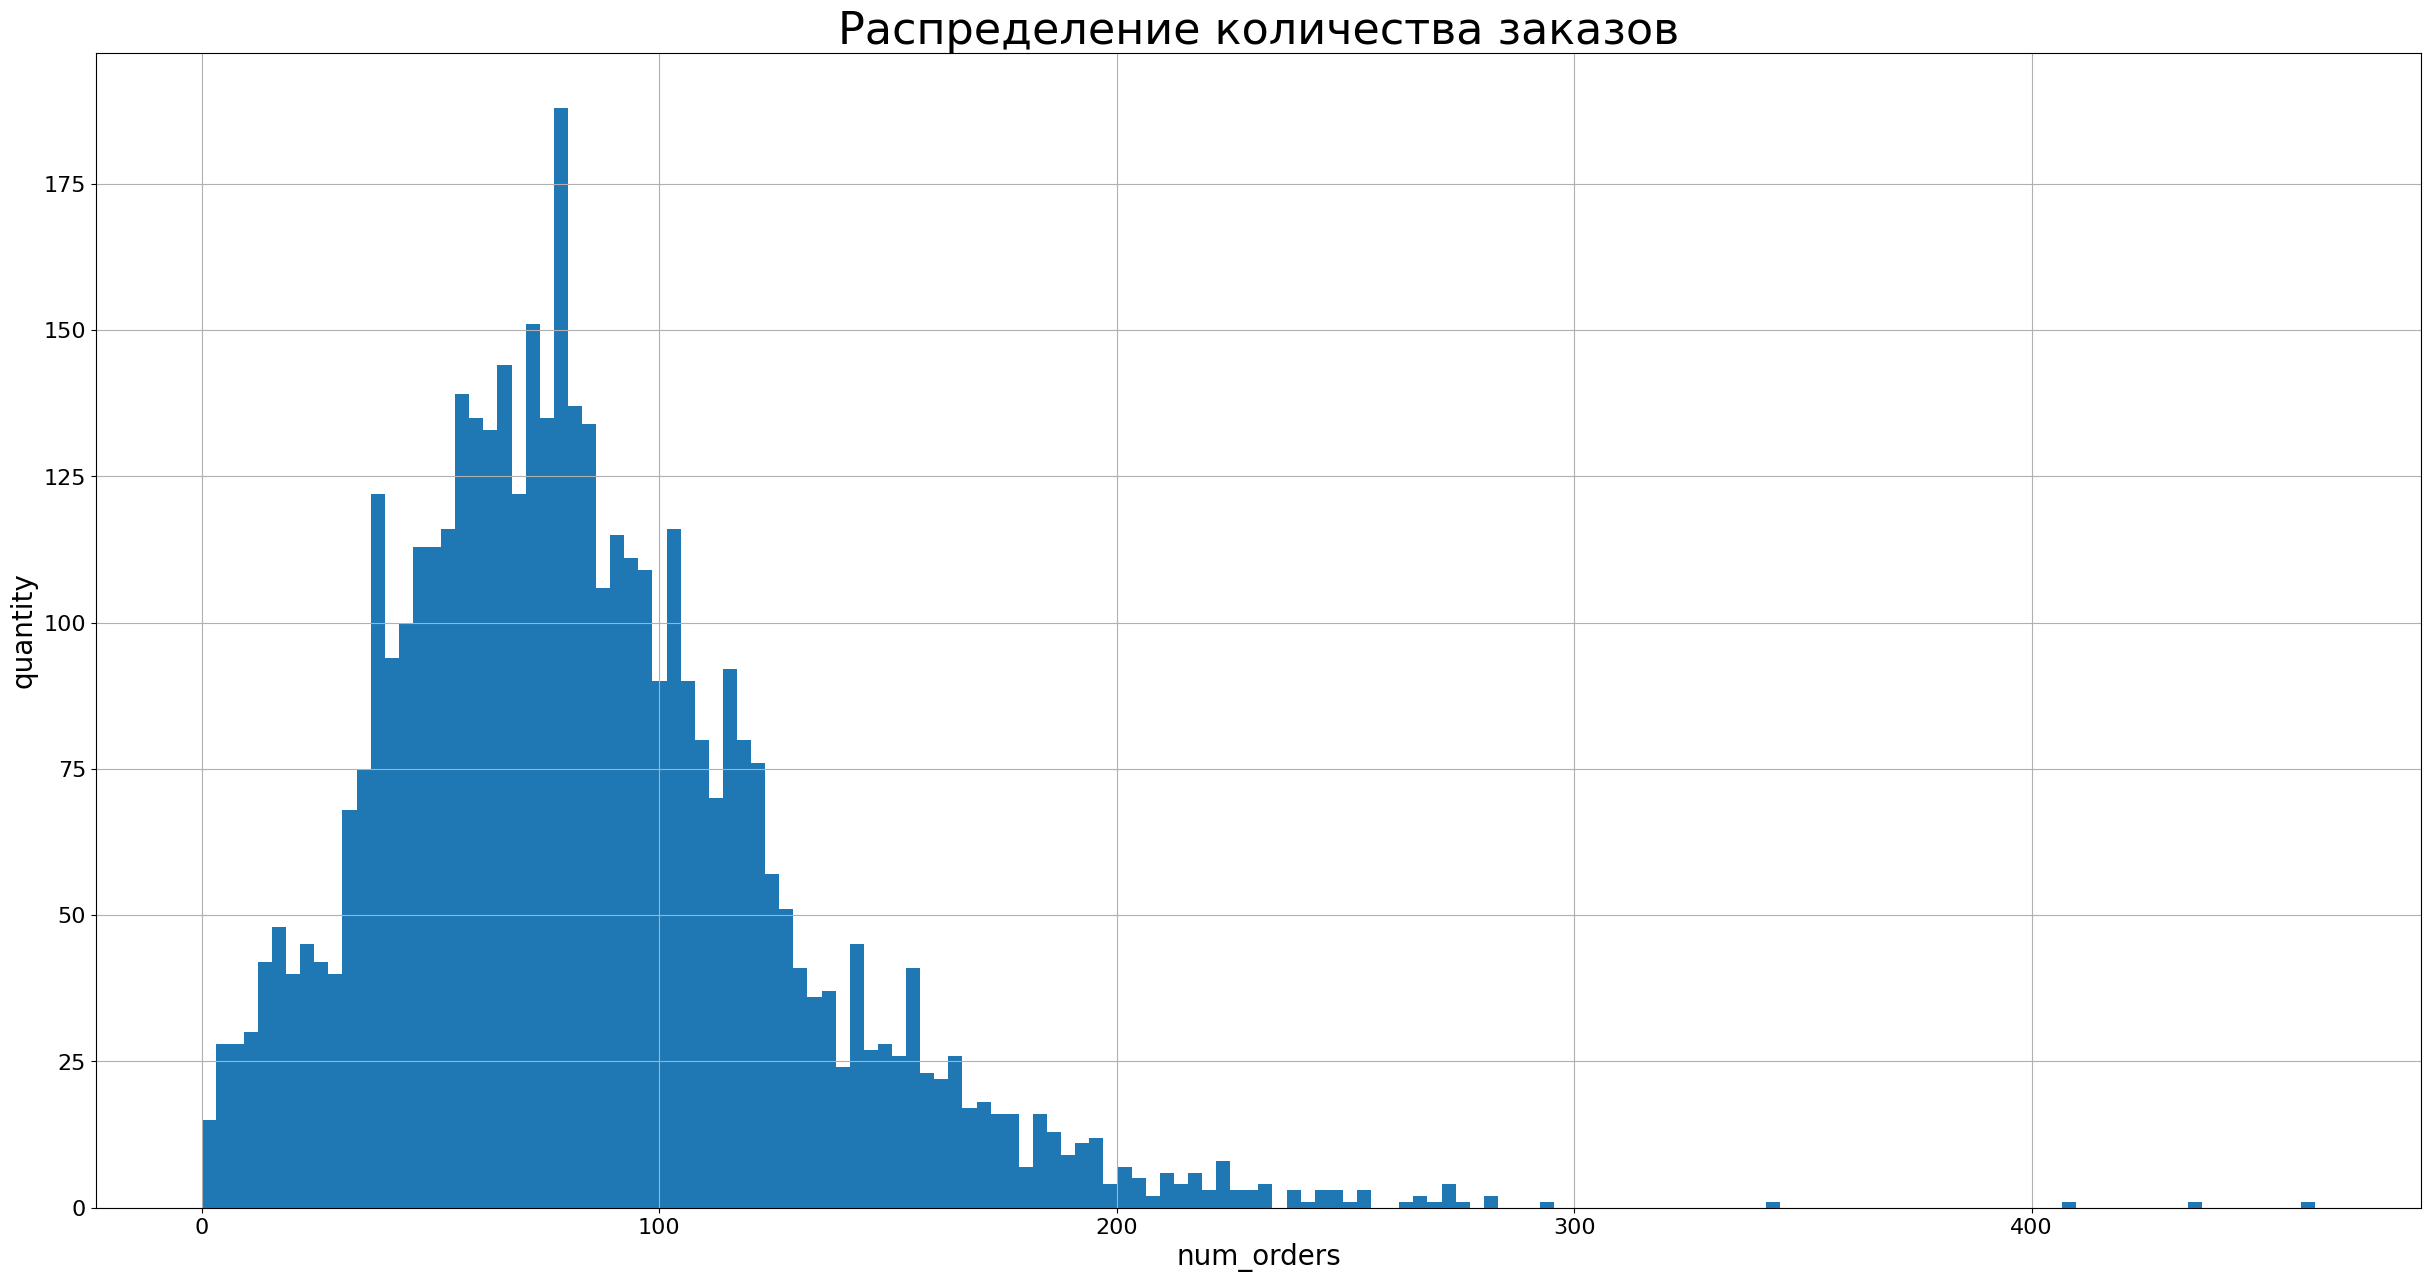

In [341]:
plt.figure(figsize=(30, 15))
plt.hist(data, bins=150)
plt.title('Распределение количества заказов', fontsize=32)
plt.xlabel("num_orders", fontsize=20)
plt.ylabel("quantity", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid()

plt.show()



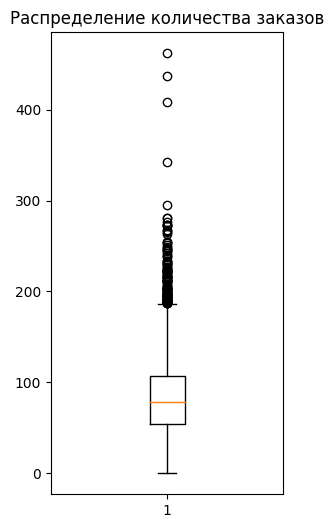

In [342]:
plt.figure(figsize=(3, 6))
plt.boxplot(data['num_orders'])
plt.title('Распределение количества заказов')
plt.show()

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

In [343]:
#data.loc[data['num_orders'] > 330,'num_orders'].index

In [344]:
#for value in data.loc[data['num_orders'] > 330,'num_orders'].index:
#    data.loc[value, 'num_orders'] = np.nan

#data = data.fillna(method = 'ffill')

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> В данных нет ошибок, а аномалии просто так выкидывать нельзя, так что данные изменять нельзя.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Поняла, поправила
</div>


<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> ОК.
</div>

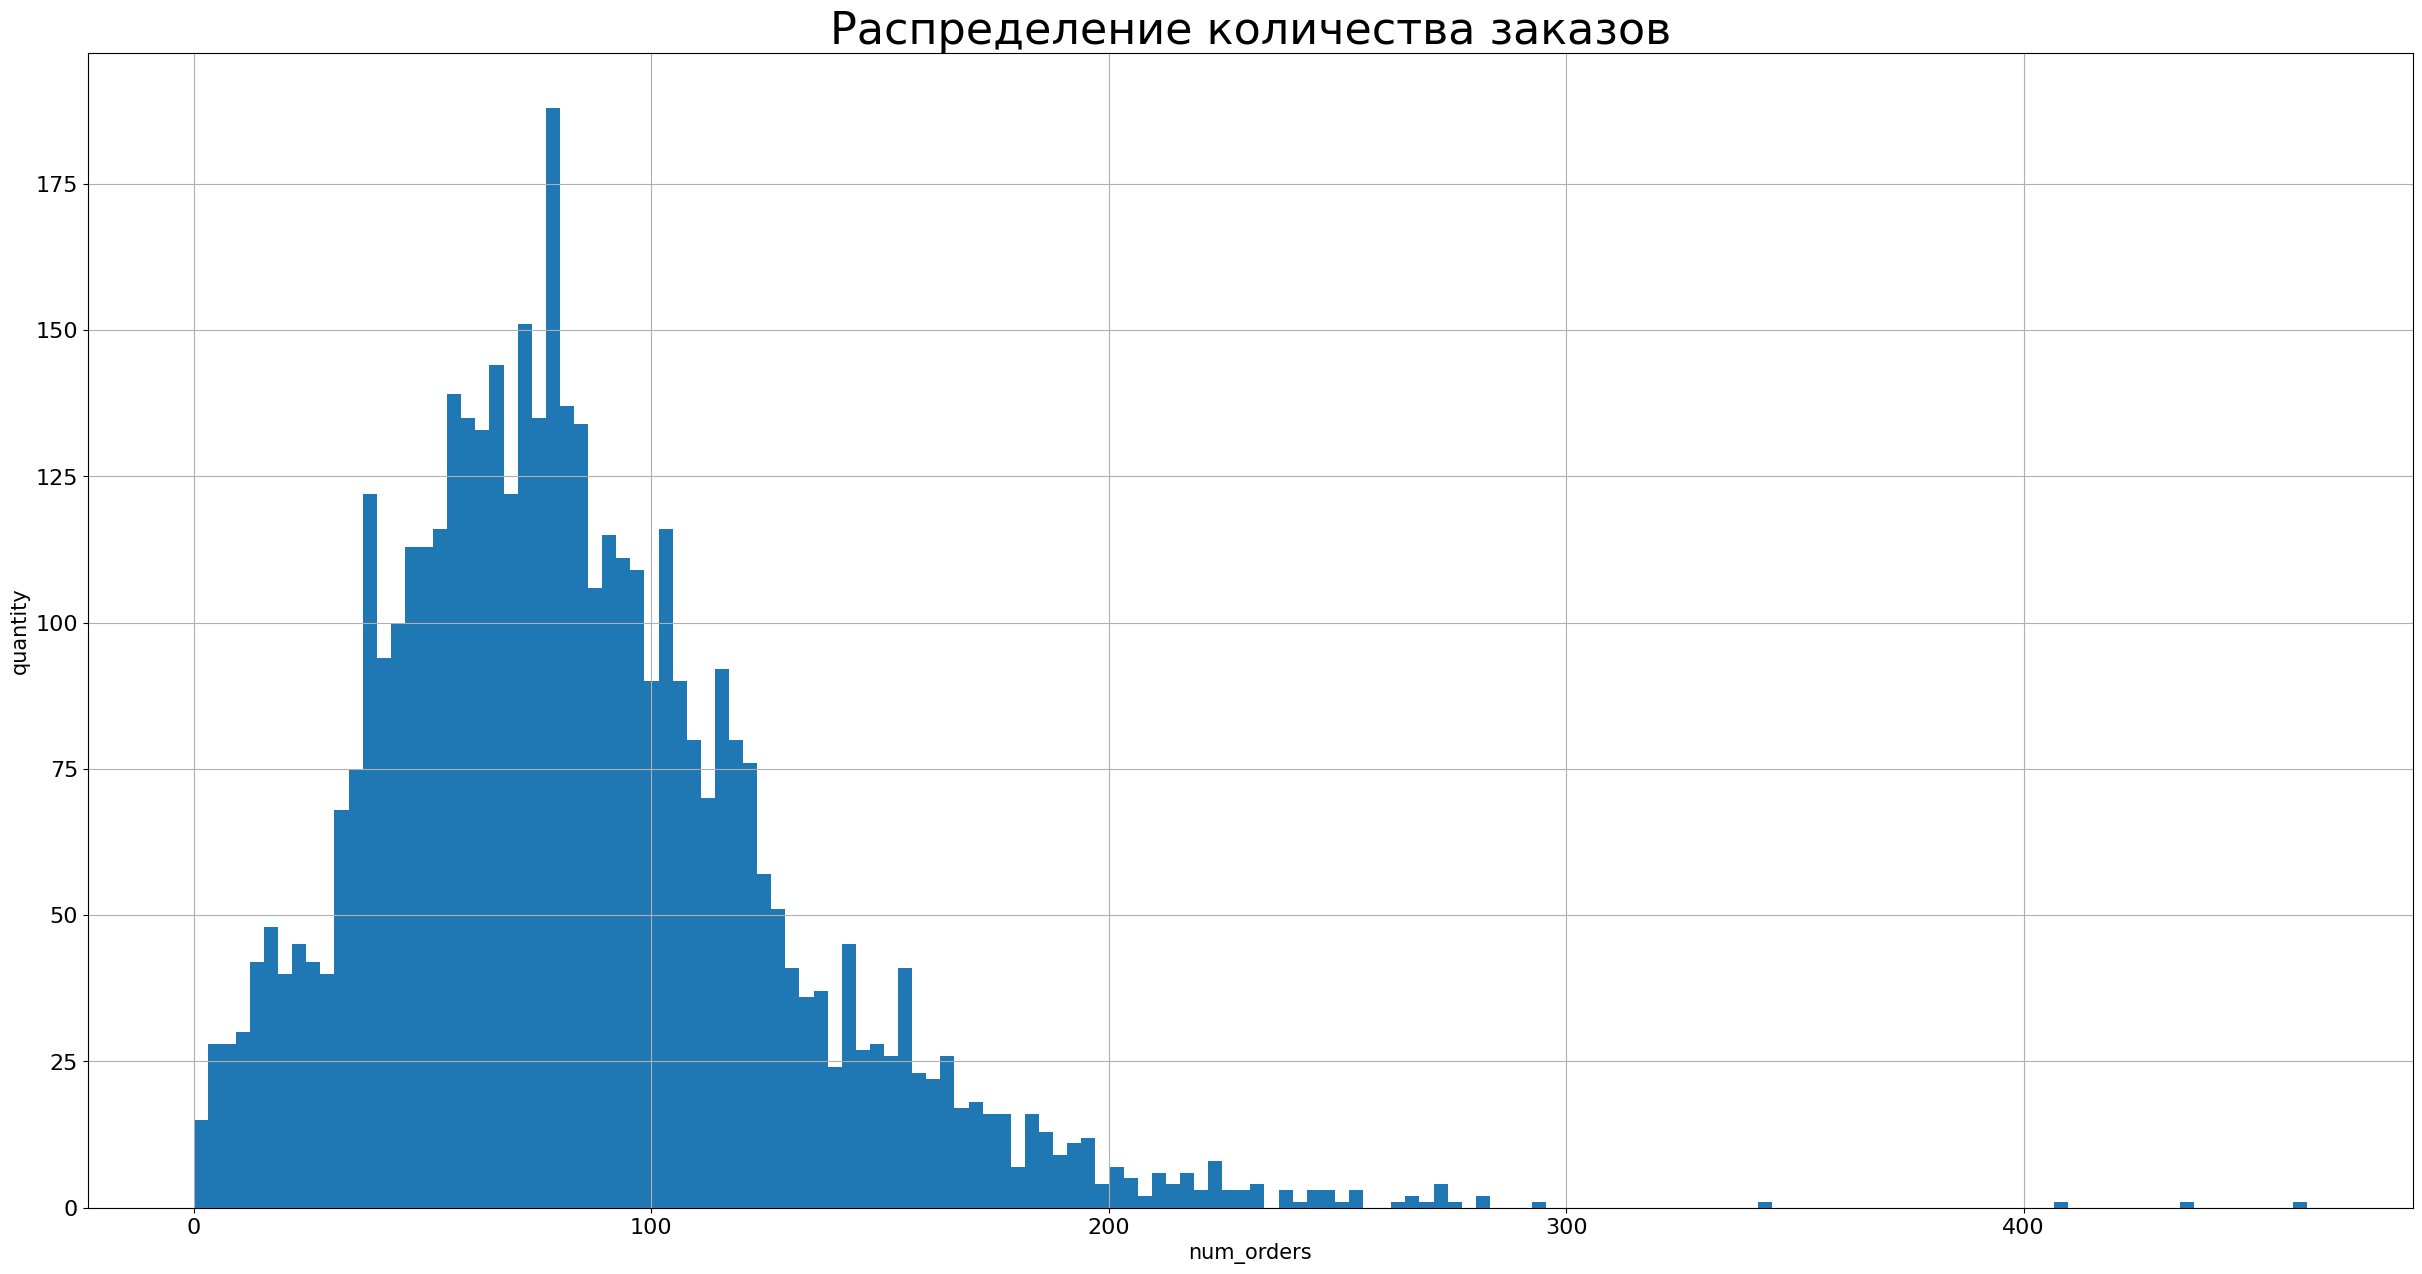

In [345]:
plt.figure(figsize=(30, 15))
plt.hist(data, bins=150)
plt.title('Распределение количества заказов', fontsize=32)
plt.xlabel("num_orders", fontsize=15)
plt.ylabel("quantity", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid()

plt.show()

Провели ресемплинг по часу, проверили пропуски и явные дубликаты, выбросы заменили, использую метод ffill.

## Анализ

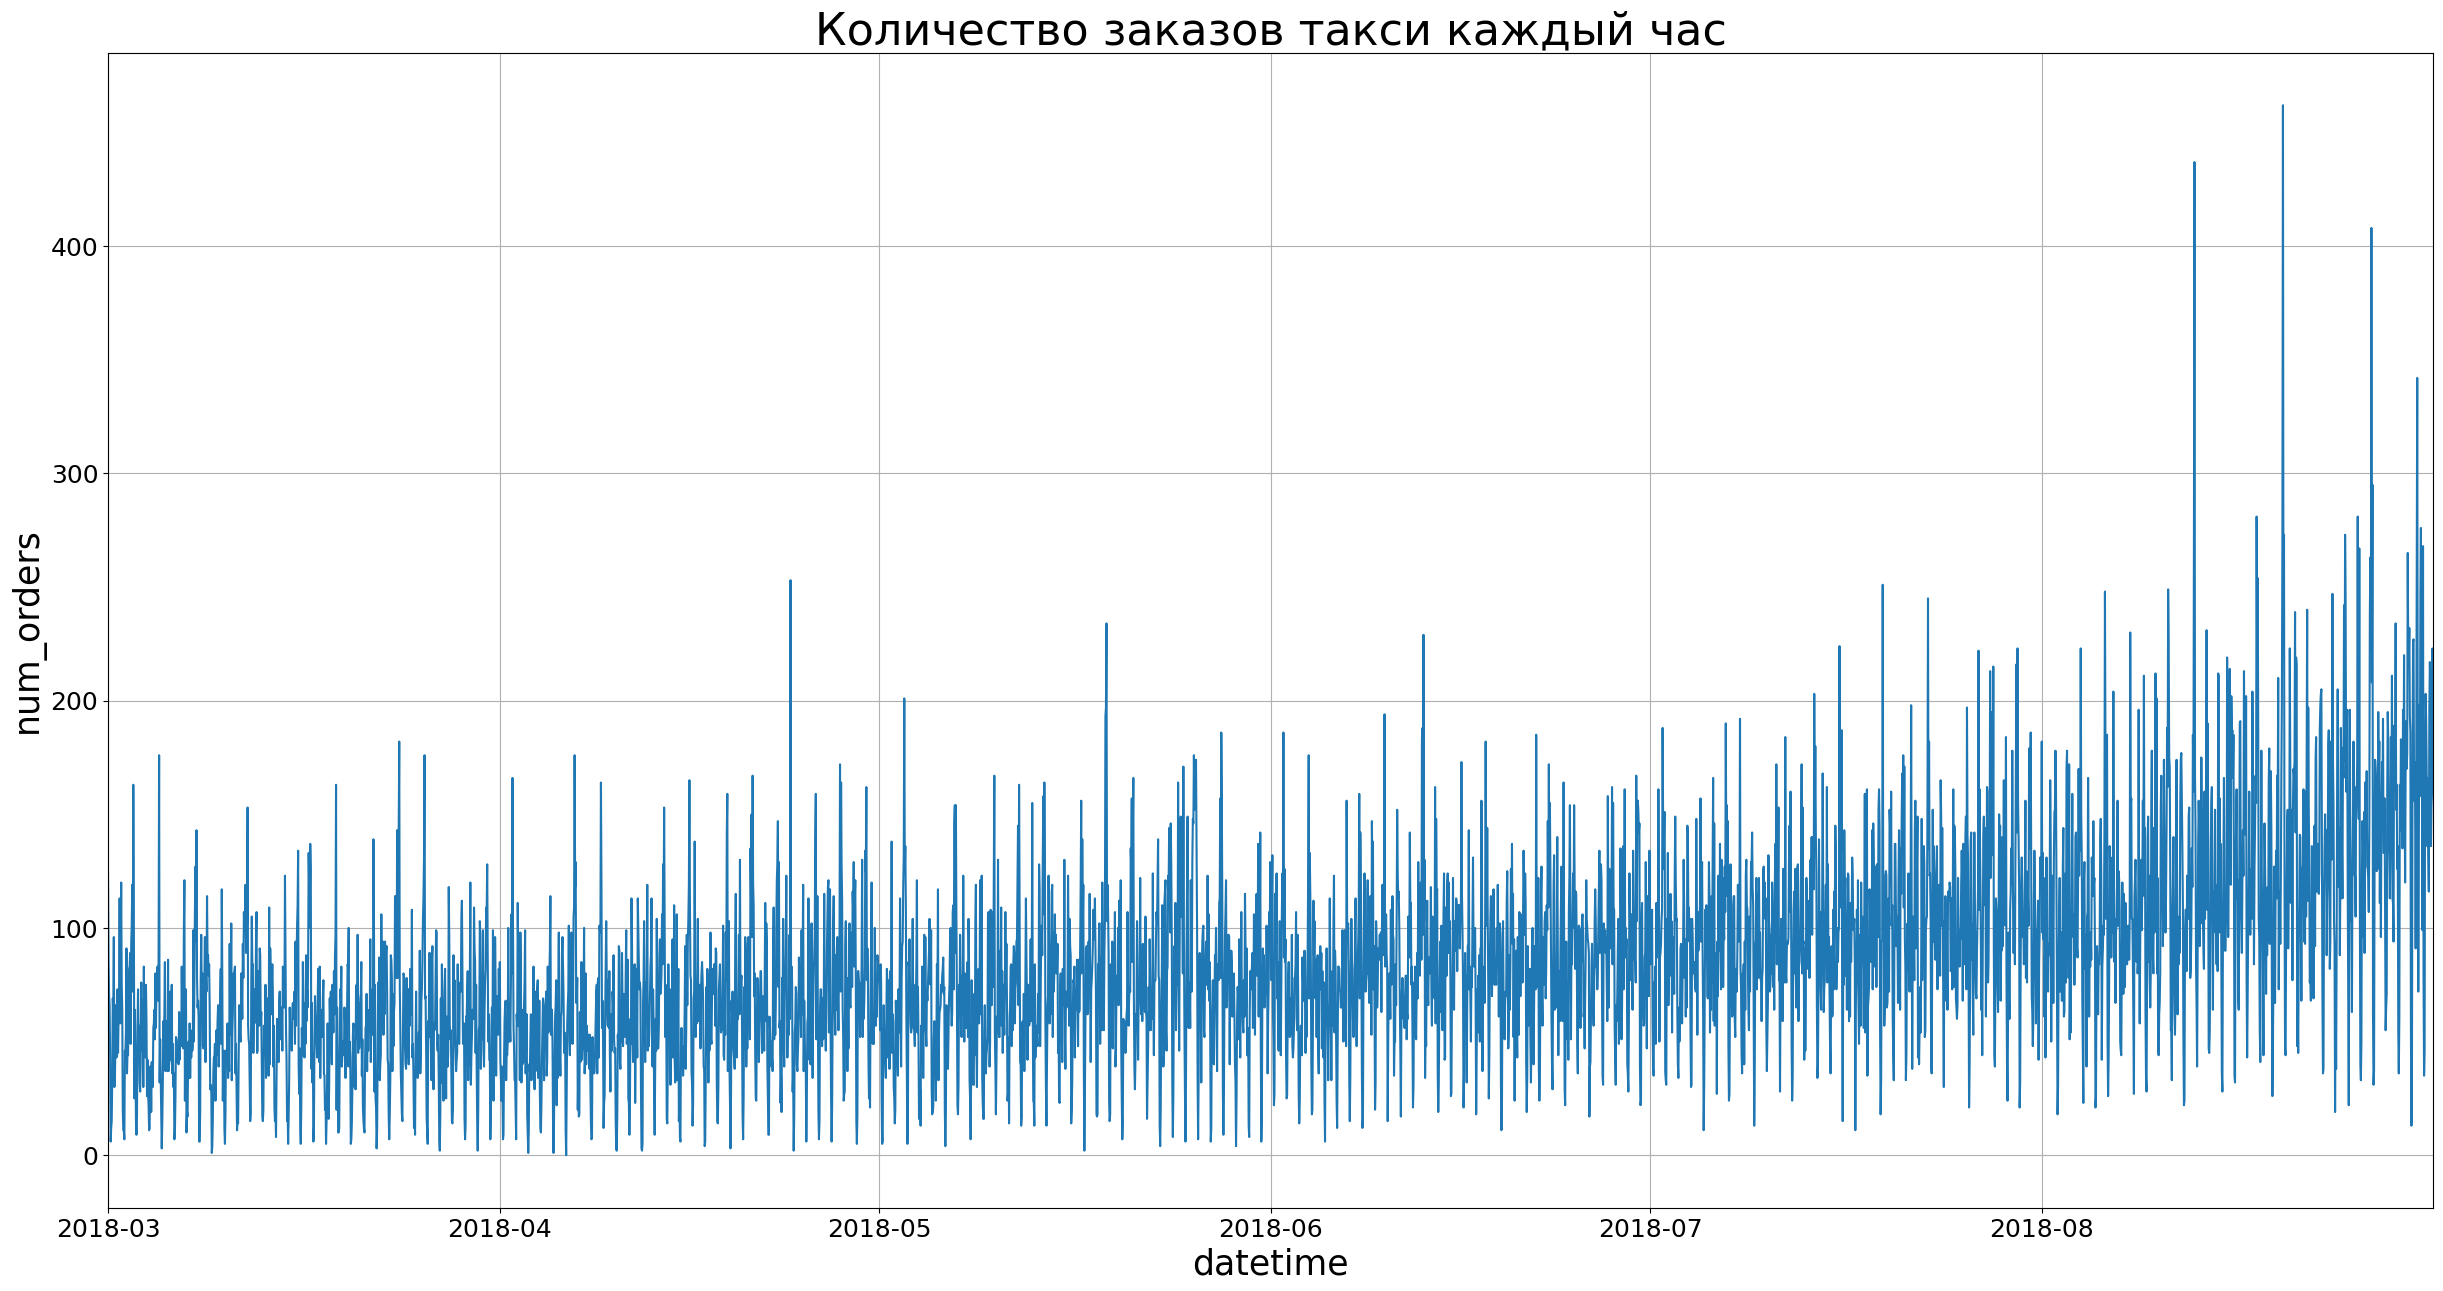

In [346]:
plt.figure(figsize=(30, 15))
plt.plot(data)

plt.xlabel("datetime", fontsize=25)
plt.ylabel("num_orders", fontsize=25)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Количество заказов такси каждый час', fontsize=32)
plt.xlim(data.index[0],data.index[-1])

plt.show()

In [347]:
description = data.describe()
description

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

In [348]:
print('V = ', float(description.values[2]/description.values[1]*100), '%') # Коэффициент вариации

V =  53.33140296285983 %


Значительная степень рассеивания данных.

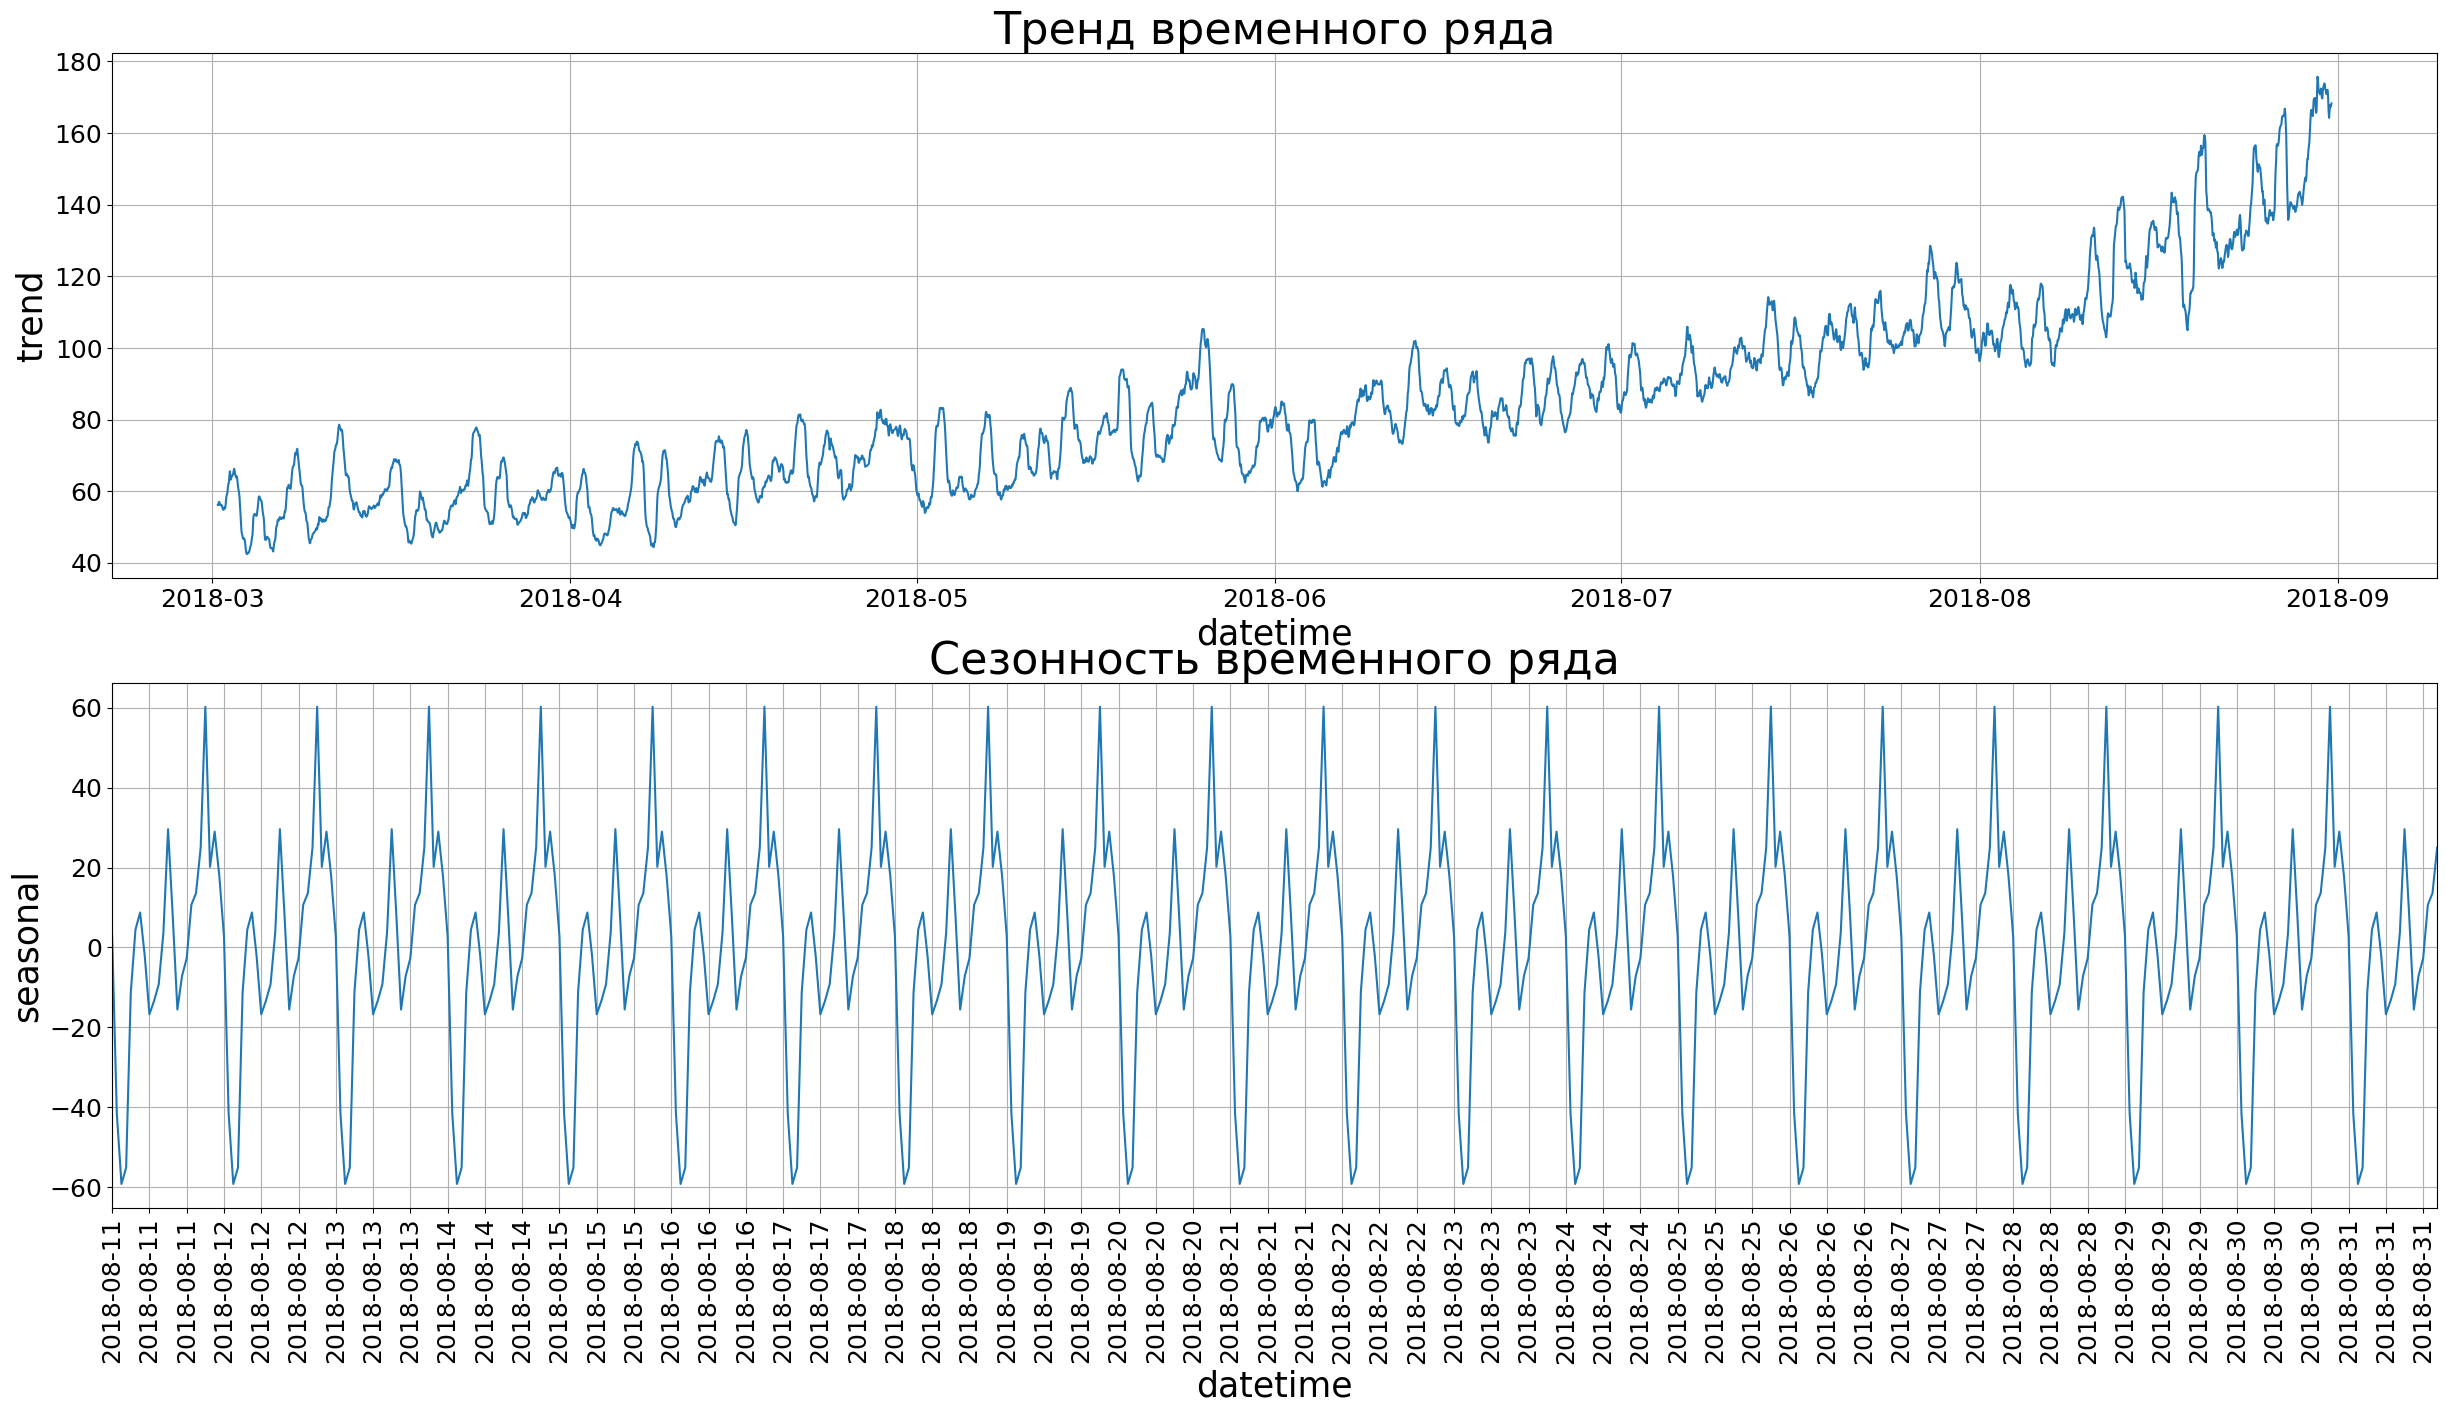

In [349]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(30, 15))
plt.subplot(2, 1, 1)

plt.plot(decomposed.trend)
plt.title('Тренд временного ряда', fontsize=32)
plt.xlabel("datetime", fontsize=25)
plt.ylabel("trend", fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid()
 
plt.subplot(2, 1, 2)
plt.plot(decomposed.seasonal)
plt.xlabel("datetime", fontsize=25)
plt.ylabel("seasonal", fontsize=25)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Сезонность временного ряда', fontsize=32)
plt.xlim(data.index[-500],data.index[-1])
plt.xticks(data.index[-500: -1:8], rotation ='vertical')

plt.show()

Растущий тренд. Сезон - сутки. Временной ряд нестационарный. Меняется среднее значение (увеличивается) и также меняется стандартное отклонение (увеличивается в конце ряда). Подтвердим это тестом.

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

Нулевая гипотеза: временной ряд не является стационарным (имеет единичный корень, т. е. некоторую зависящую от времени структуру). Альтернативная гипотеза: временной ряд является стационарным.

In [350]:
test = sm.tsa.adfuller(data.num_orders) # Расширенный тест Дики-Фуллера
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])
if test[0]> test[4]['1%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -3.0689242890279513
p-value: 0.02894005140261326
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
есть единичные корни, ряд не стационарен


In [351]:
def invboxcox(y,lmbda):# функция для обратного преобразования Бокса-Кокса
    '''Выполняет обратное преобразование Бокса-Кокса'''
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [352]:
# Уменьшаем дисперсию преобразованием Бокса-Кокса
data['boxcox'], lmbda = stats.boxcox(data.num_orders + 1) # прибавляем единицу, так как в исходном ряде есть нули
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.499598


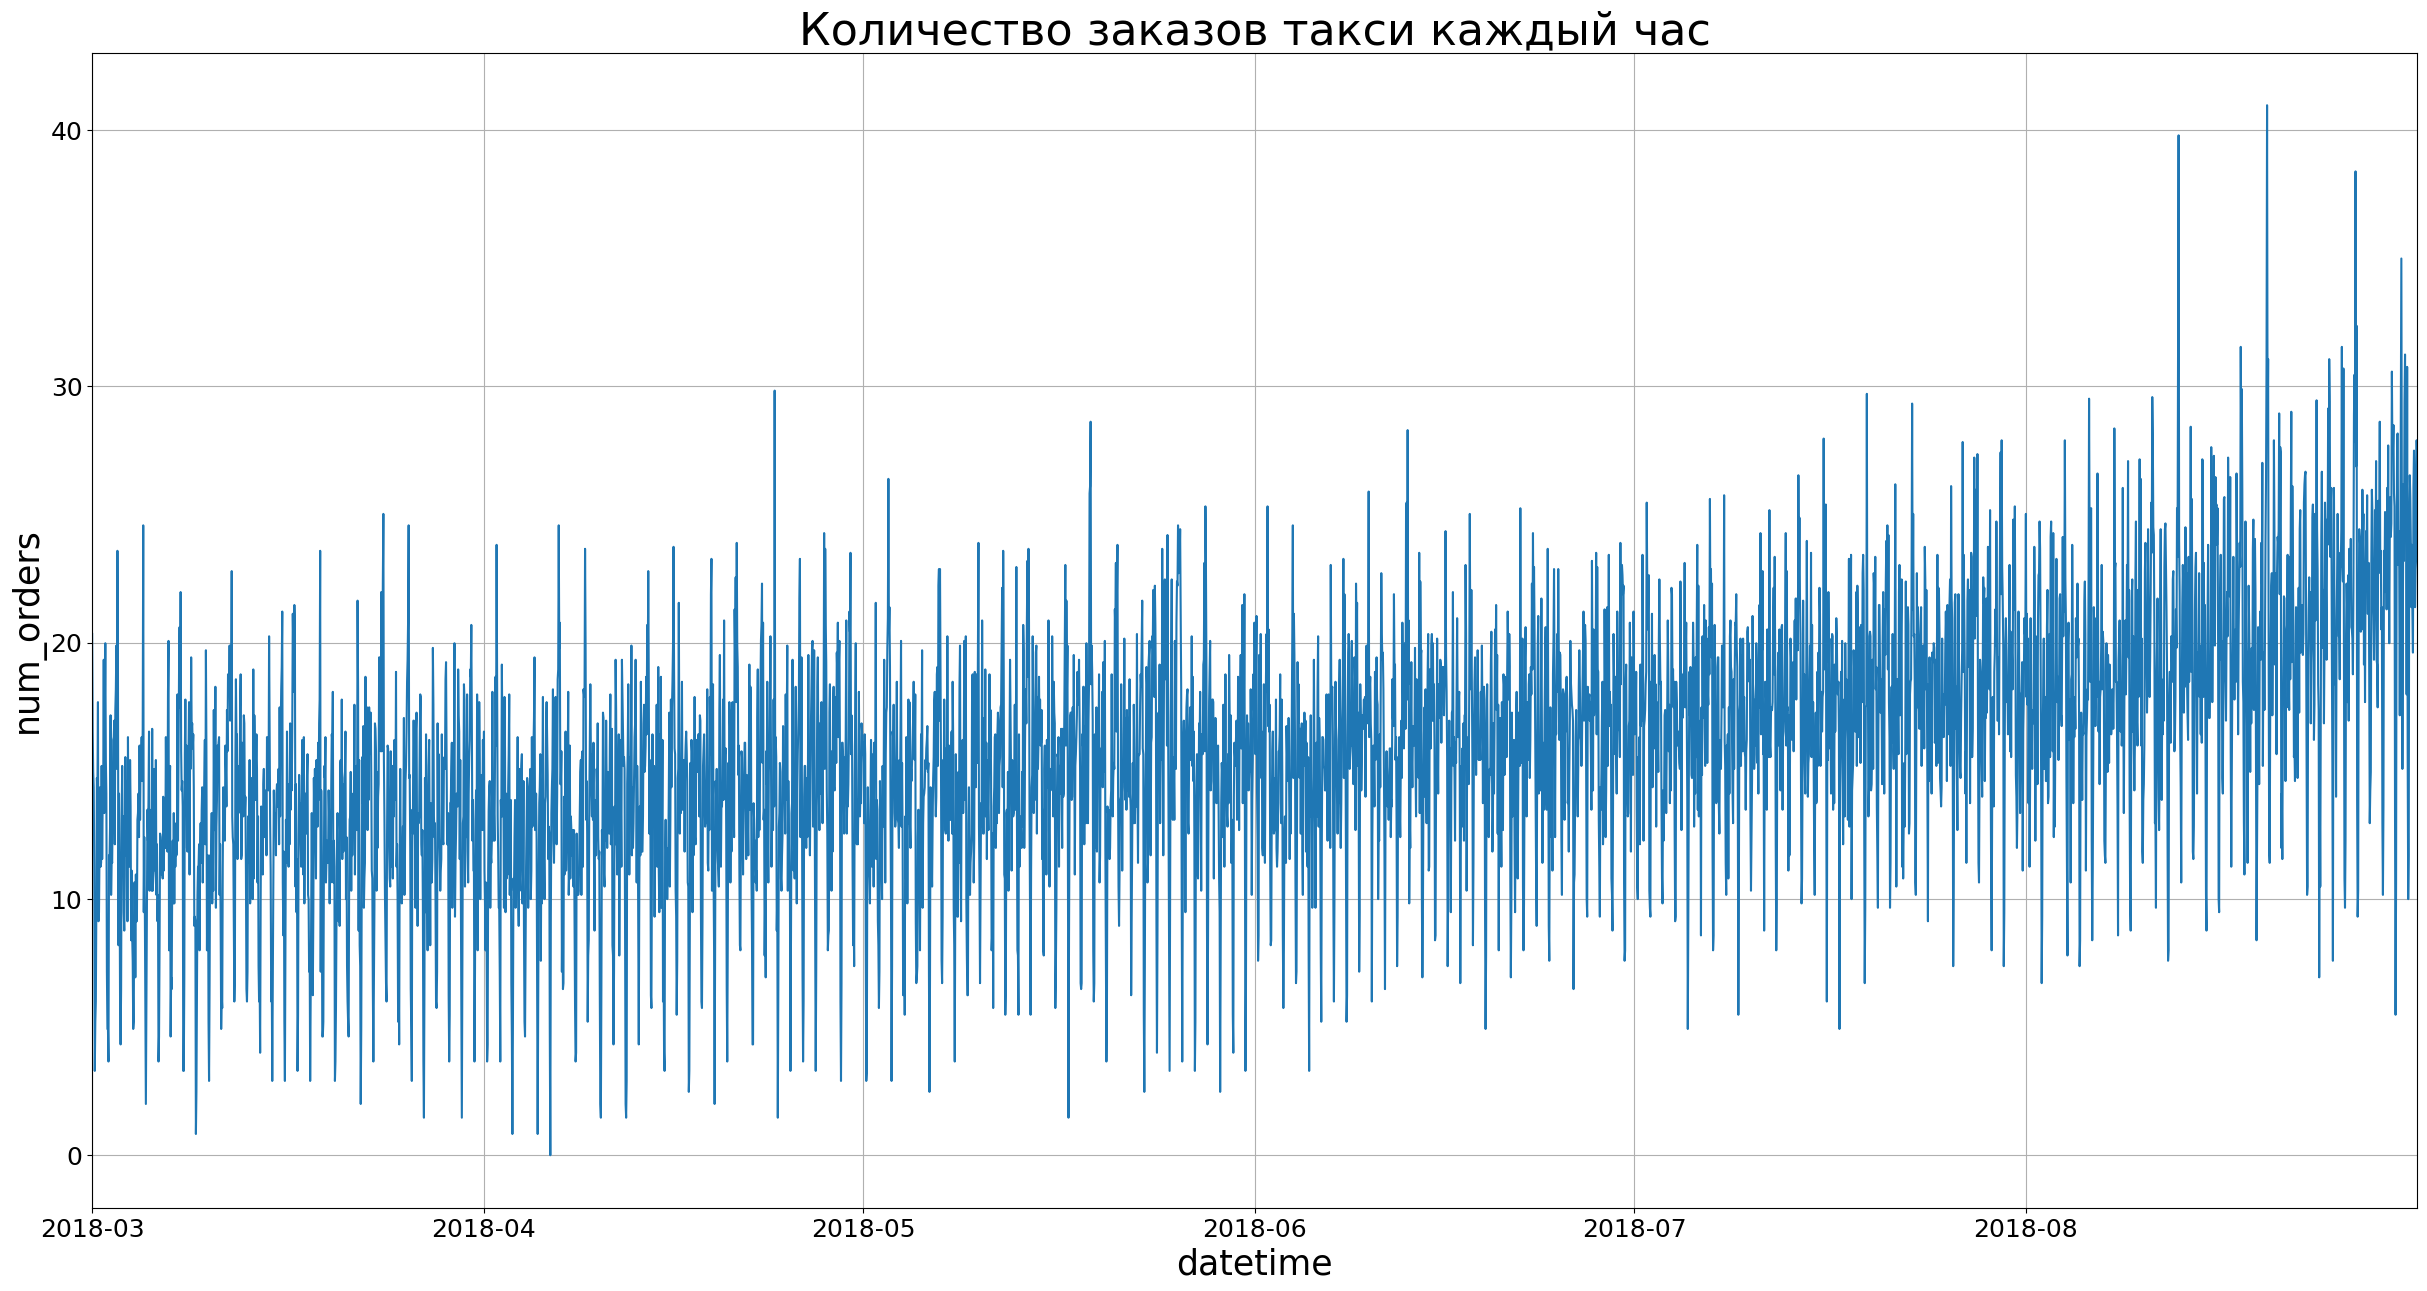

In [353]:
plt.figure(figsize=(30, 15))
plt.plot(data.boxcox)

plt.xlabel("datetime", fontsize=25)
plt.ylabel("num_orders", fontsize=25)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Количество заказов такси каждый час', fontsize=32)
plt.xlim(data.index[0],data.index[-1])

plt.show()

In [354]:
description = data.boxcox.describe()
print('V = ', float(description.values[2]/description.values[1]*100), '%') # Коэффициент вариации

V =  30.936871288896988 %


In [355]:
test = sm.tsa.adfuller(data.boxcox)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])
if test[0]> test[4]['1%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -3.3279120083707823
p-value: 0.013675985293498604
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
есть единичные корни, ряд не стационарен


Дисперсия стала более однородной. И p-value уменьшилось. Но ряд всё ещё не стационарный.
Проведём сезонное дифференцирование. Длина сезона в нашем случае равна 24.

In [356]:
data['boxcox_shifted_season'] = data.boxcox - data.boxcox.shift(24) # Сезонное дифференцирование

test = sm.tsa.adfuller(data.boxcox_shifted_season[24:])
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])
if test[0]> test[4]['1%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')


adf: -16.055815573974666
p-value: 5.70897397736732e-29
Critical values: {'1%': -3.4318507234354523, '5%': -2.8622031360567024, '10%': -2.567122991804141}
единичных корней нет, ряд стационарен


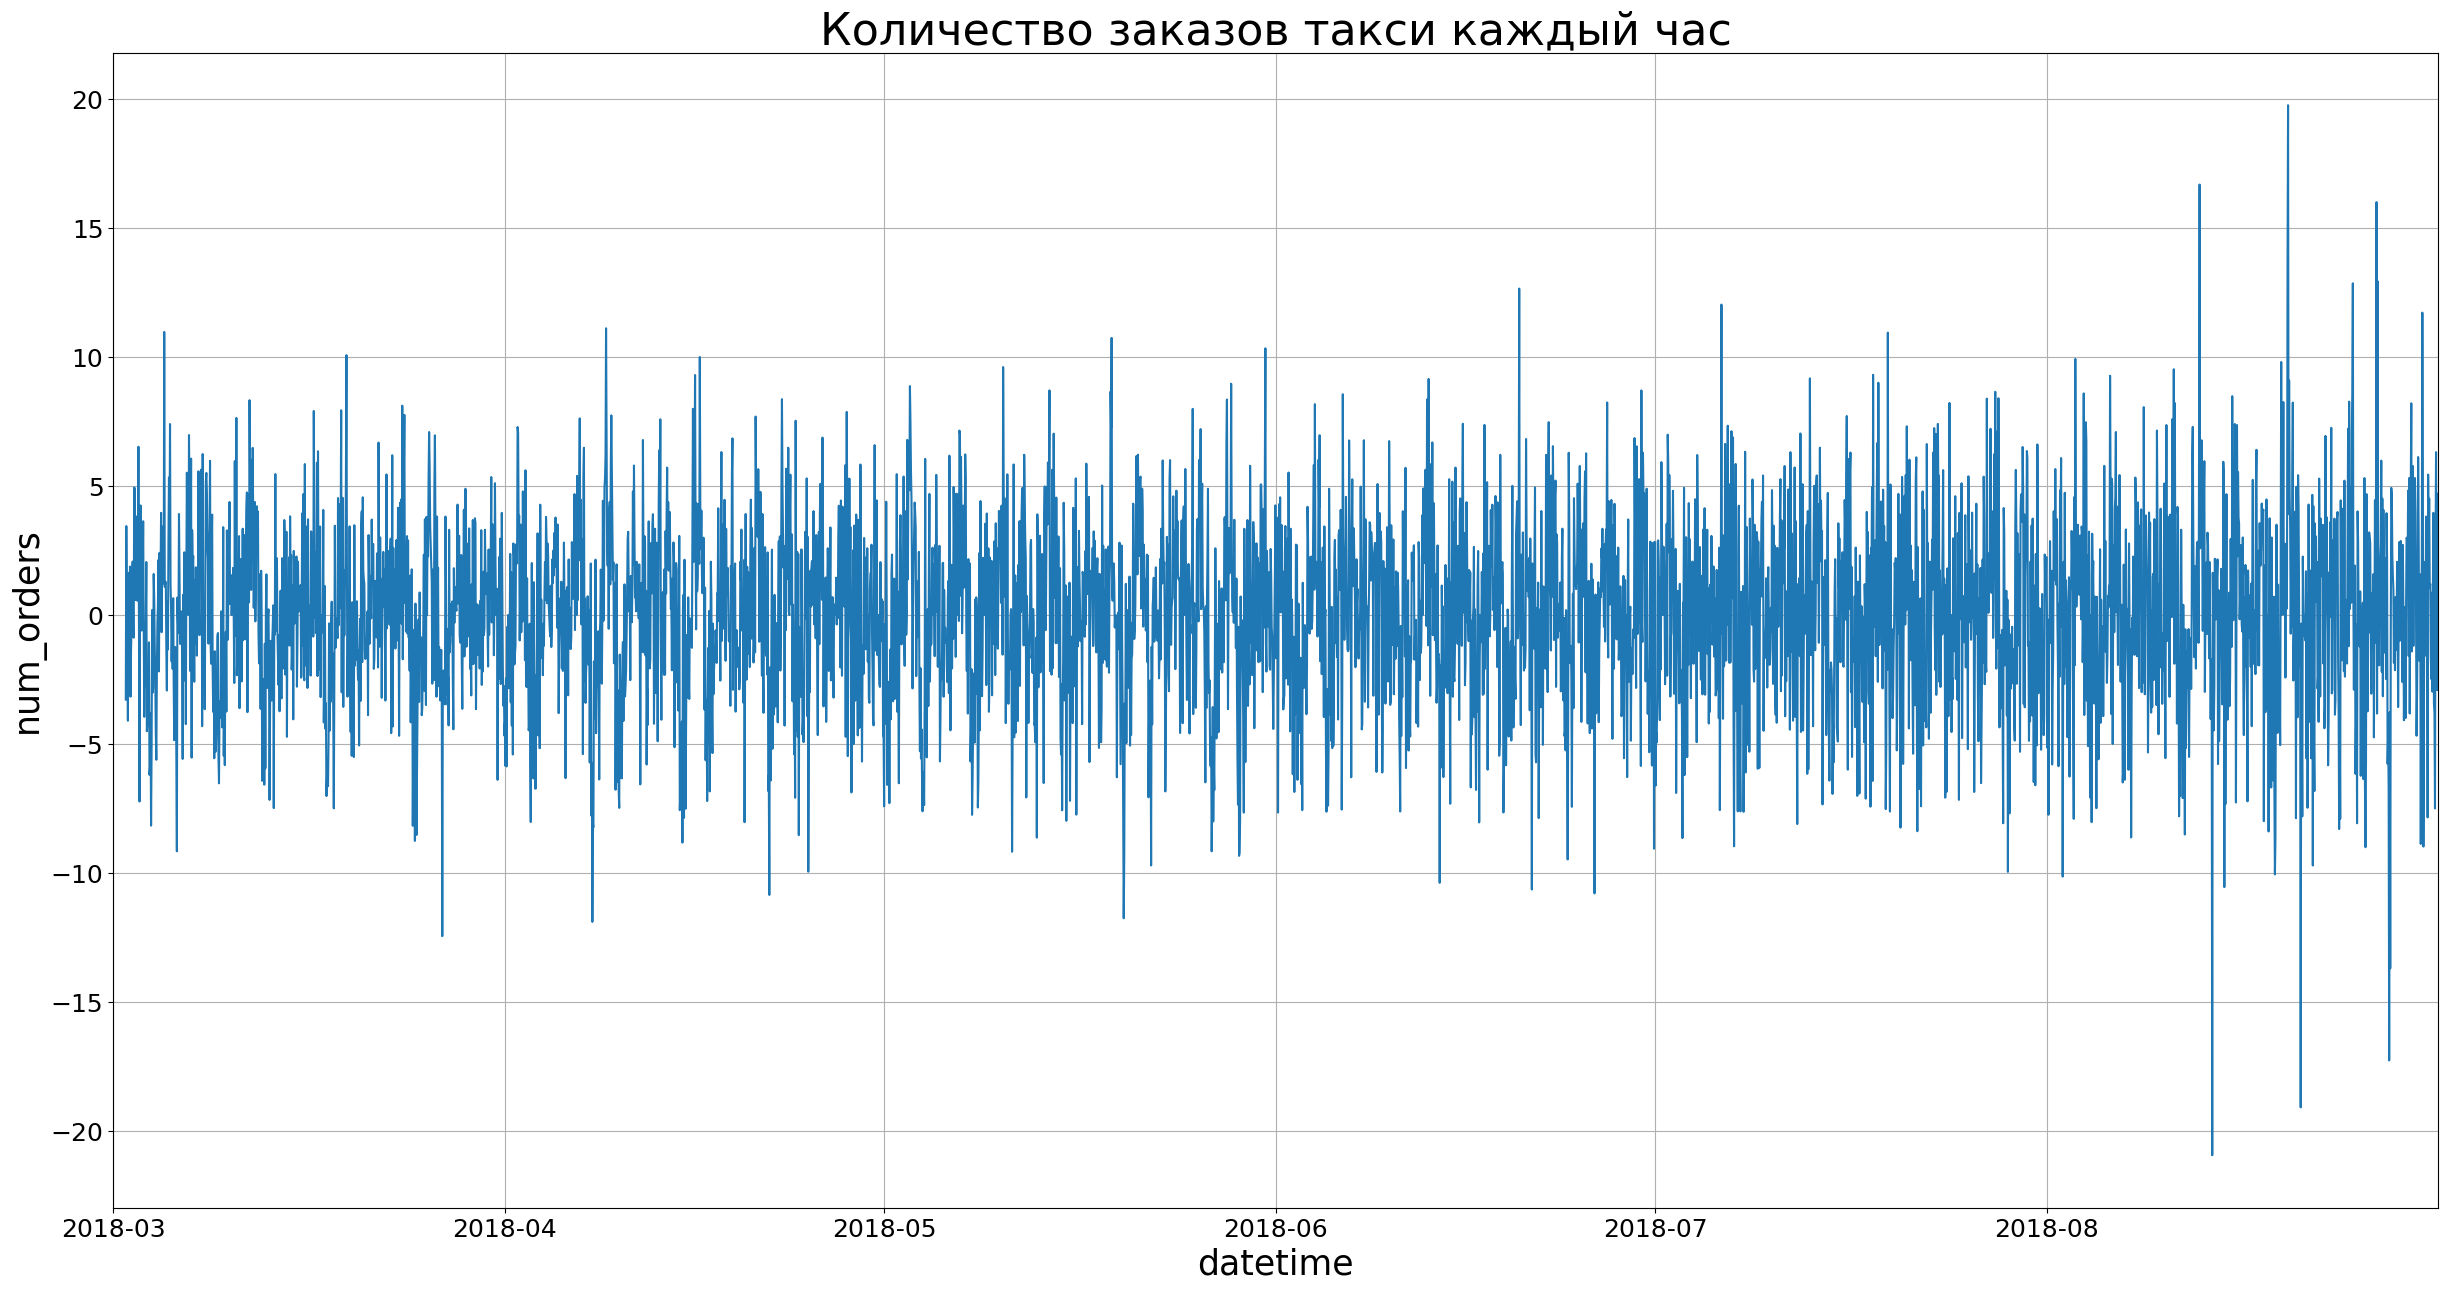

In [357]:
plt.figure(figsize=(30, 15))
plt.plot(data.boxcox_shifted_season[24:])

plt.xlabel("datetime", fontsize=25)
plt.ylabel("num_orders", fontsize=25)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Количество заказов такси каждый час', fontsize=32)
plt.xlim(data.index[0],data.index[-1])

plt.show()

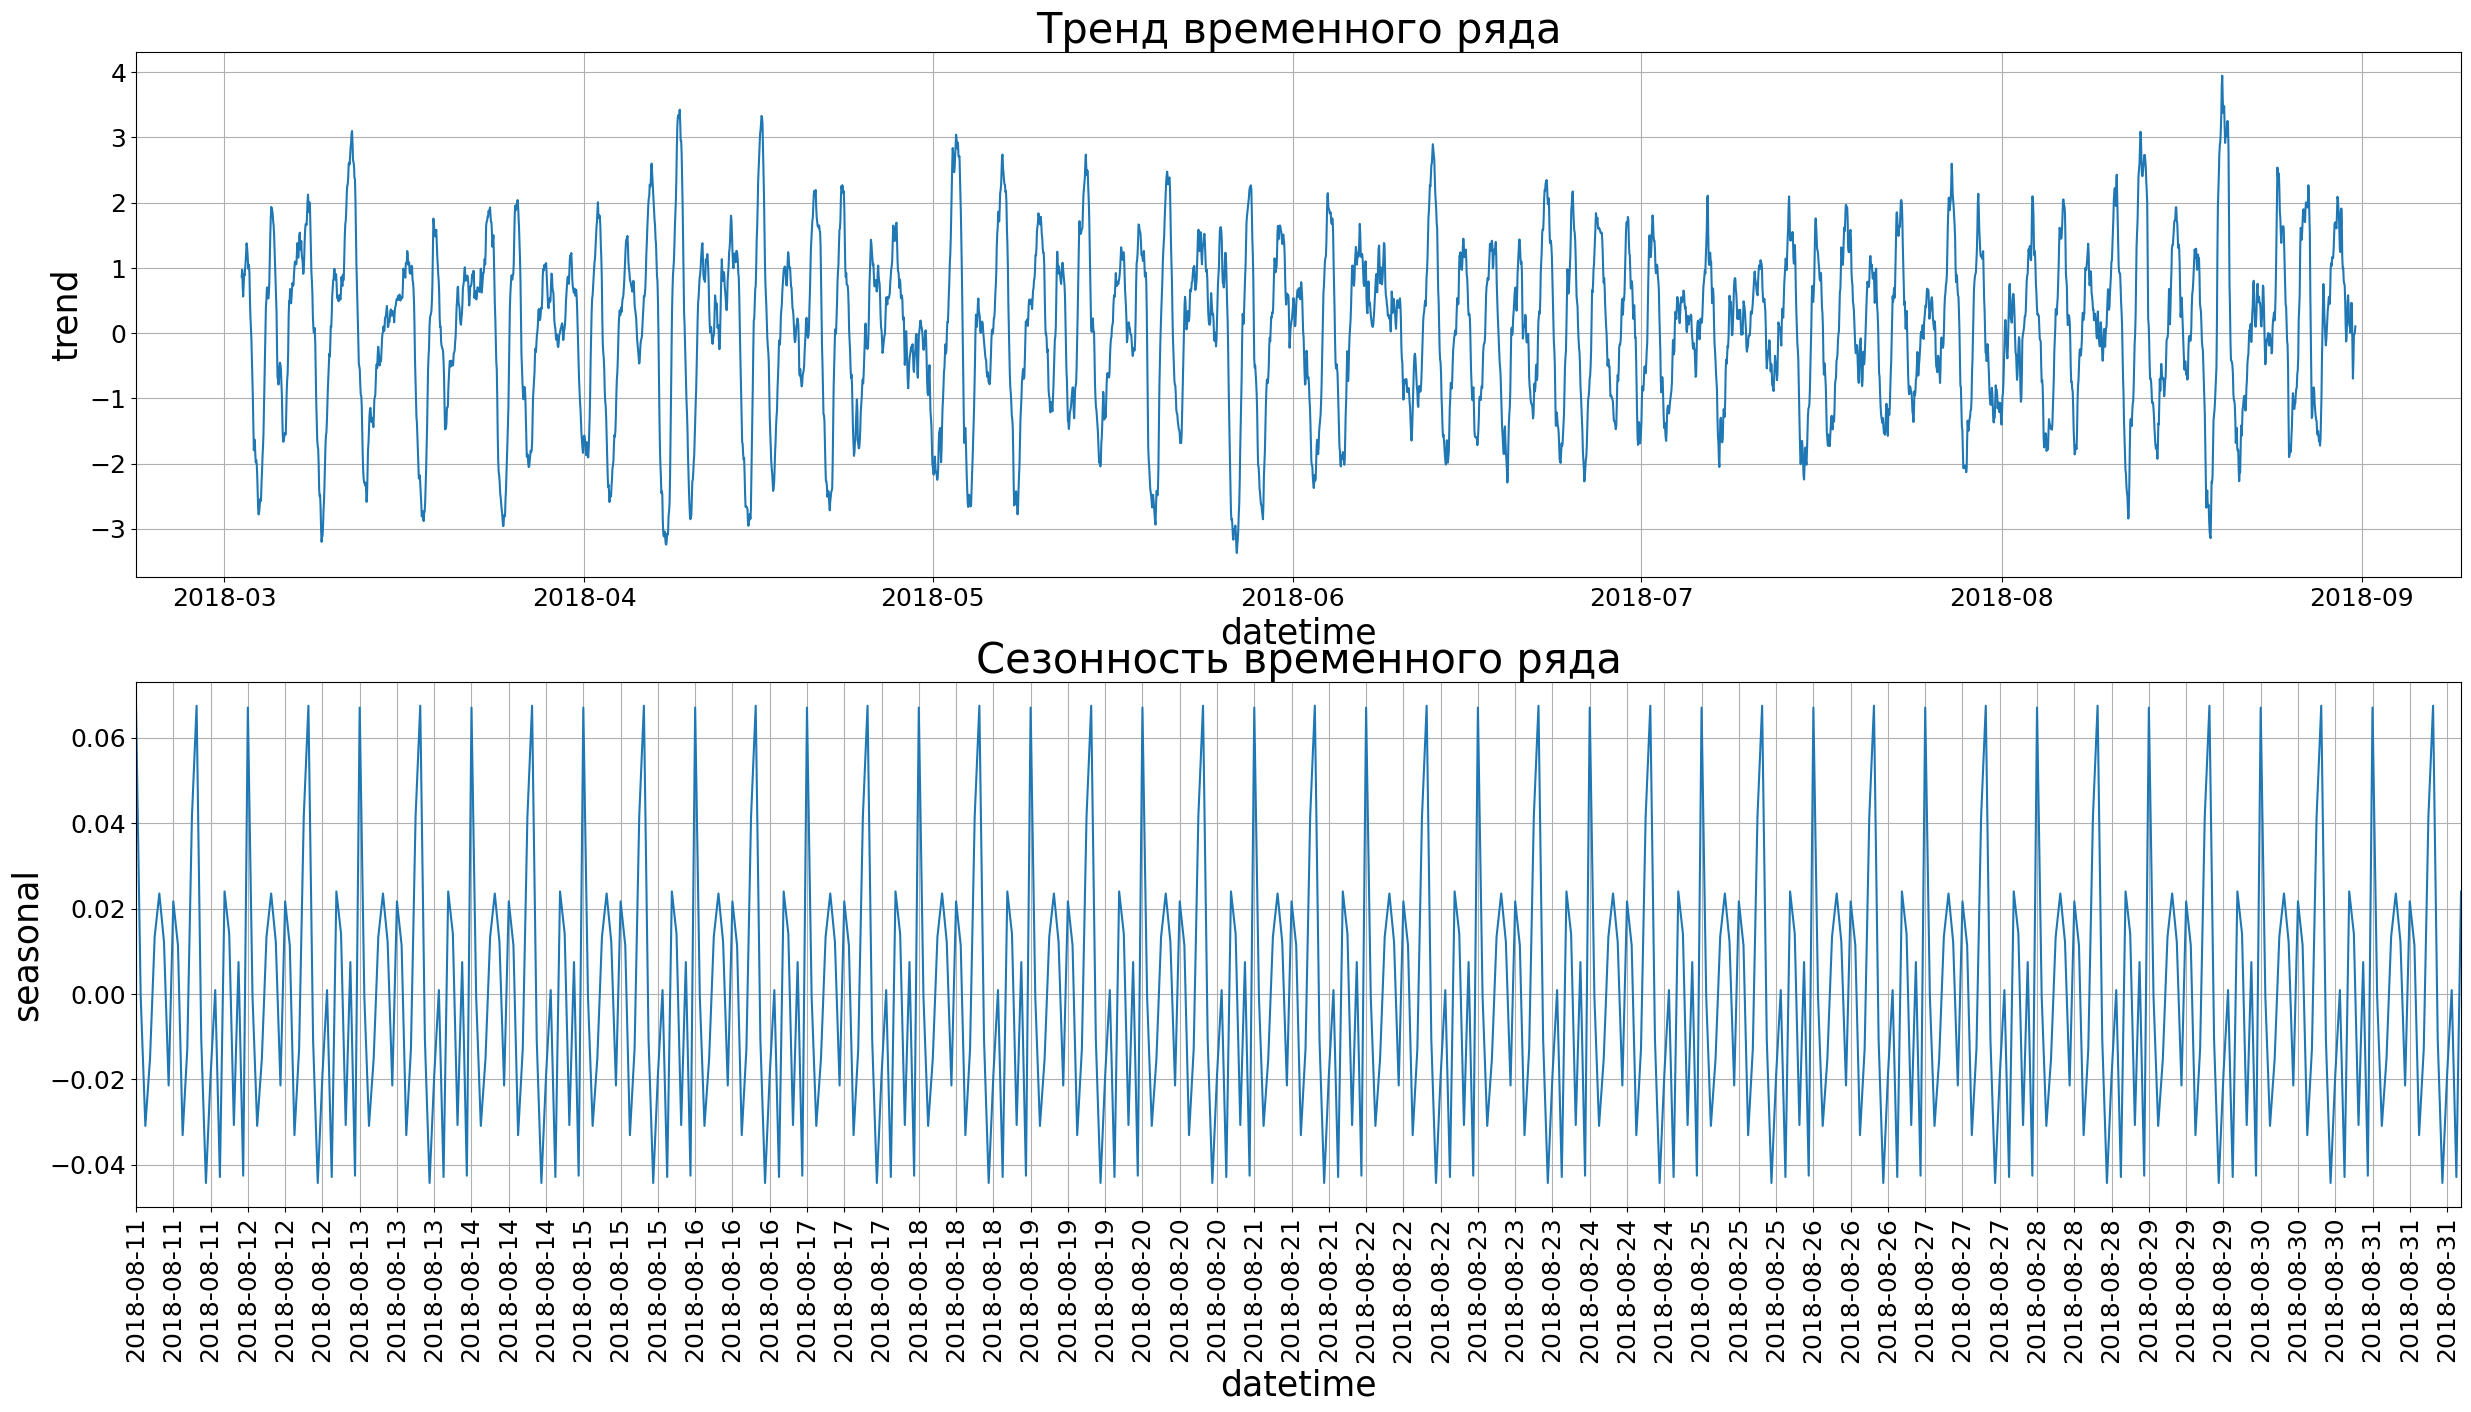

In [358]:
decomposed = seasonal_decompose(data.boxcox_shifted_season[24:])

plt.figure(figsize=(30, 15))
plt.subplot(2, 1, 1)

plt.plot(decomposed.trend)
plt.title('Тренд временного ряда', fontsize=30)
plt.xlabel("datetime", fontsize=25)
plt.ylabel("trend", fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid()
 
plt.subplot(2, 1, 2)
plt.plot(decomposed.seasonal)
plt.xlabel("datetime", fontsize=25)
plt.ylabel("seasonal", fontsize=25)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Сезонность временного ряда', fontsize=30)
plt.xlim(data.index[-500],data.index[-1])
plt.xticks(data.index[-500: -1:8], rotation ='vertical')

plt.show()

Проведем повторное сезонное дифференцирование.

In [359]:
data['boxcox_shifted_season_2'] = data.boxcox_shifted_season - data.boxcox_shifted_season.shift(24) # Сезонное дифференцирование

test = sm.tsa.adfuller(data.boxcox_shifted_season_2[48:])
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])
if test[0]> test[4]['1%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -17.028833355071136
p-value: 8.353709501875564e-30
Critical values: {'1%': -3.4318590349480904, '5%': -2.8622068077965177, '10%': -2.5671249464557433}
единичных корней нет, ряд стационарен


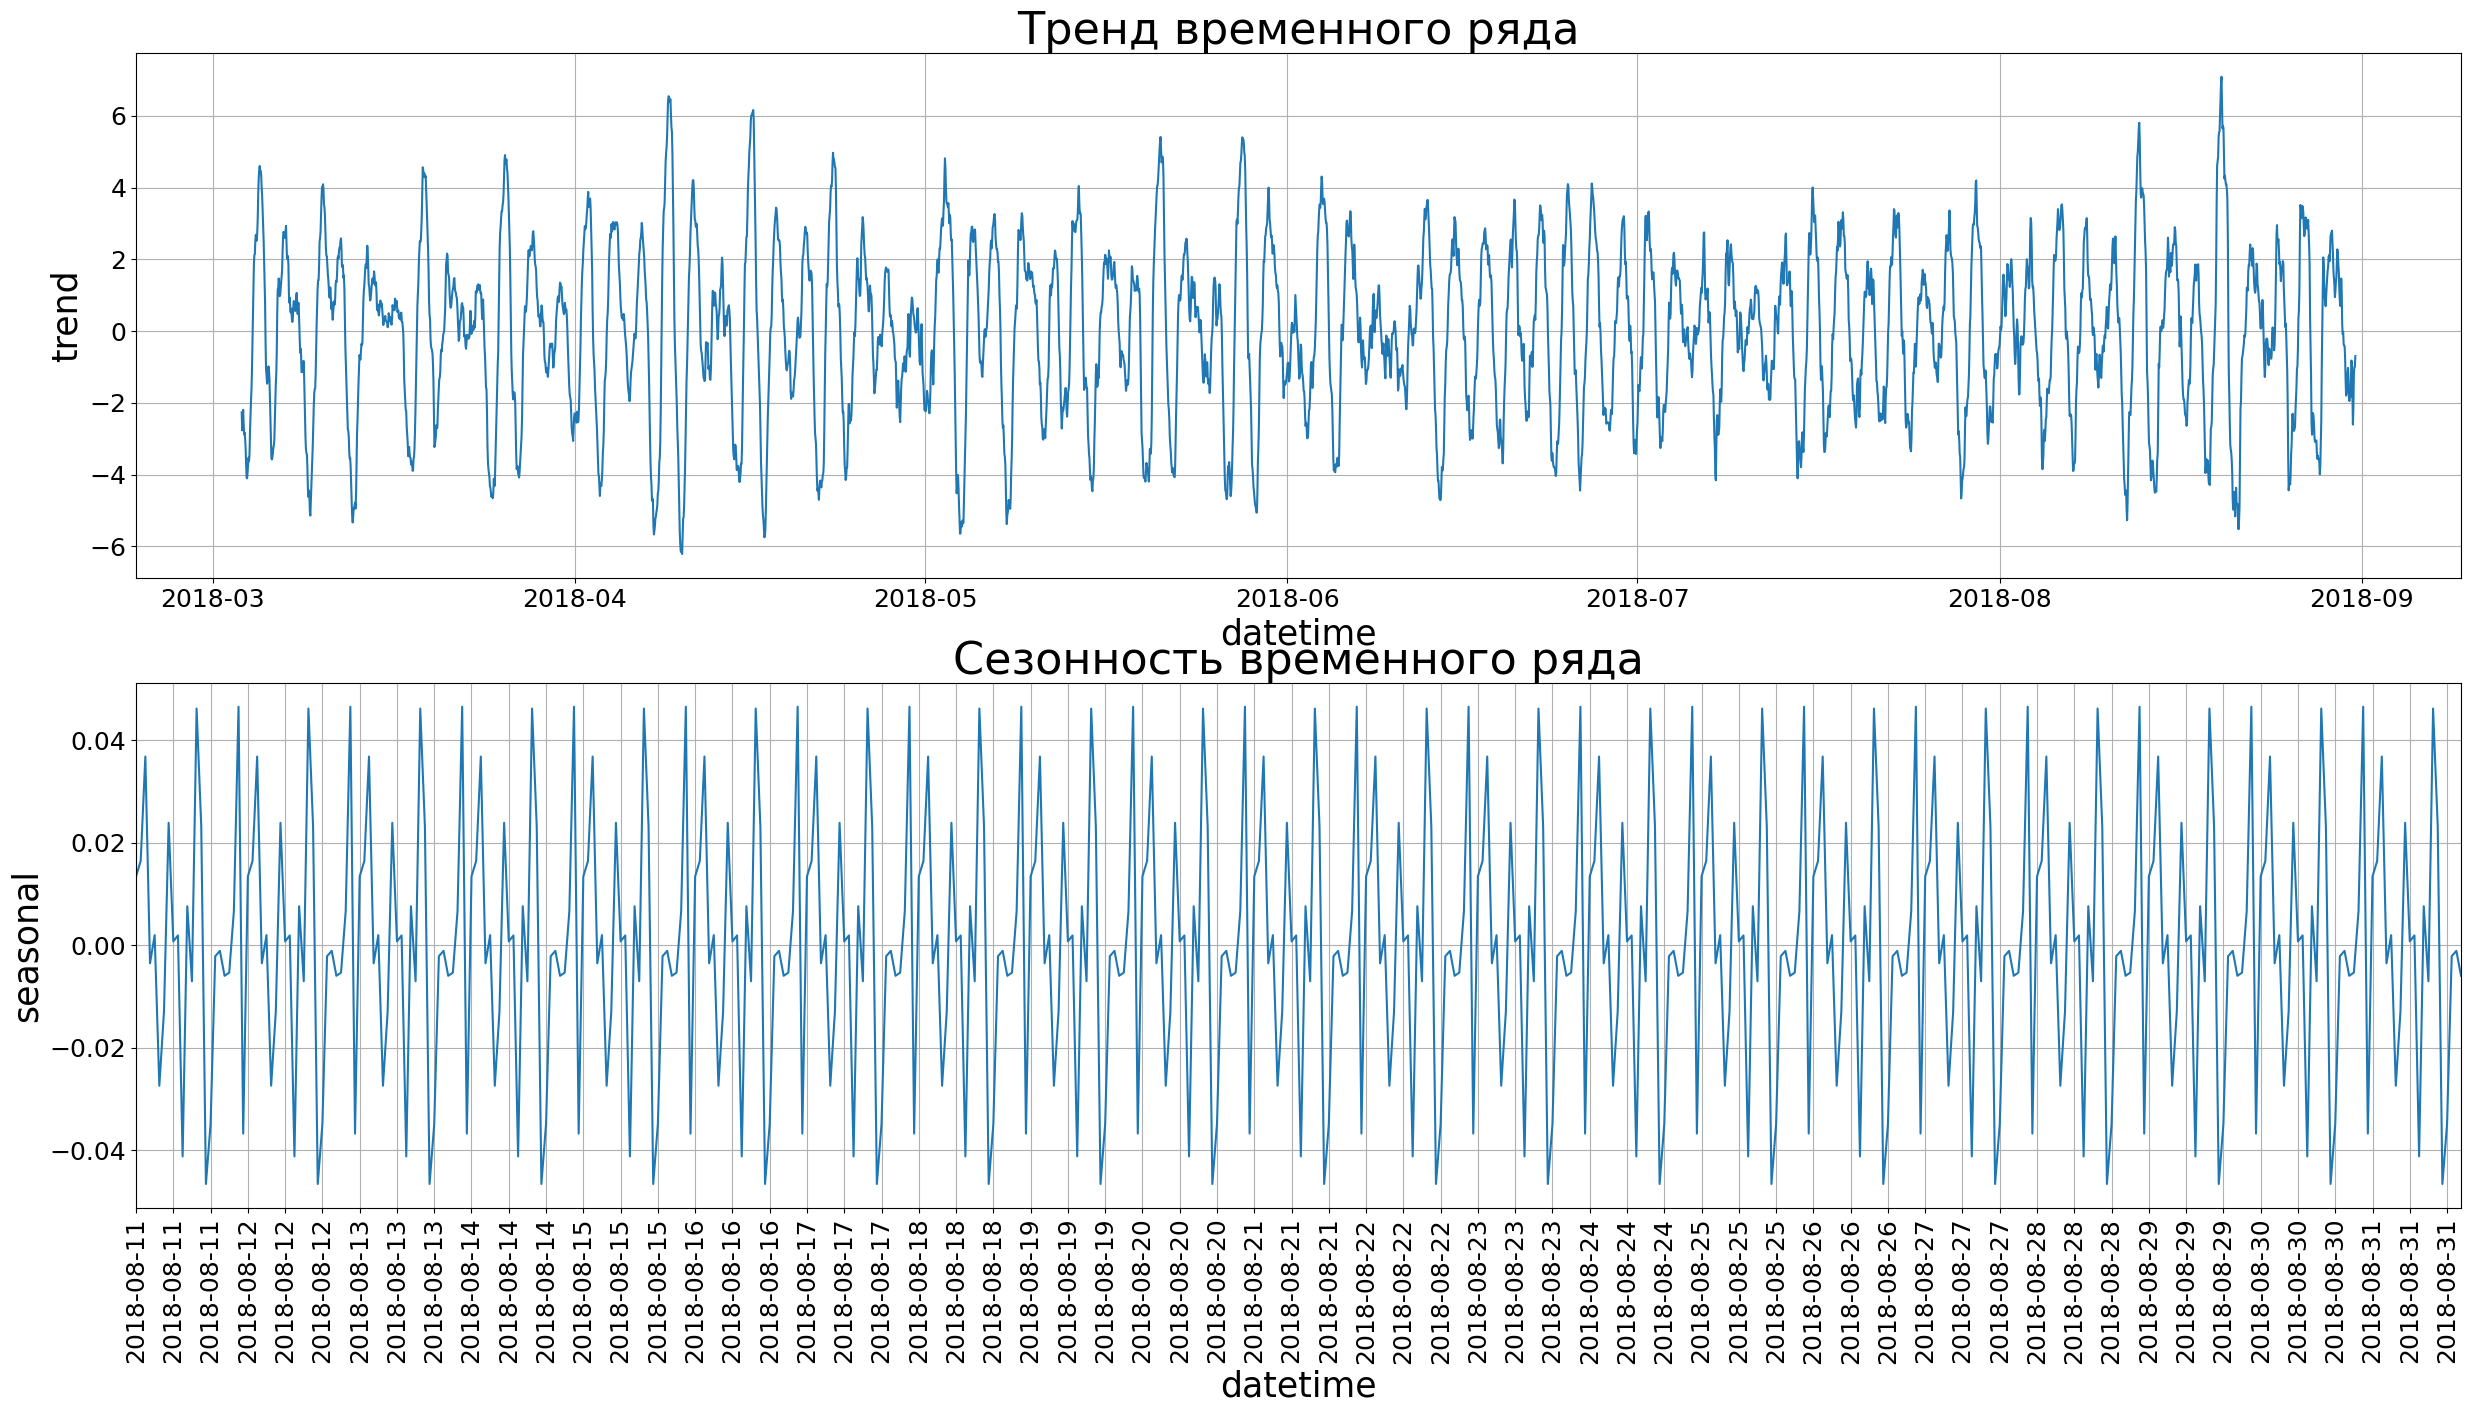

In [360]:
decomposed = seasonal_decompose(data.boxcox_shifted_season_2[48:])

plt.figure(figsize=(30, 15))
plt.subplot(2, 1, 1)

plt.plot(decomposed.trend)
plt.title('Тренд временного ряда', fontsize=32)
plt.xlabel("datetime", fontsize=25)
plt.ylabel("trend", fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid()
 
plt.subplot(2, 1, 2)
plt.plot(decomposed.seasonal)
plt.xlabel("datetime", fontsize=25)
plt.ylabel("seasonal", fontsize=25)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Сезонность временного ряда', fontsize=32)
plt.xlim(data.index[-500],data.index[-1])
plt.xticks(data.index[-500: -1:8], rotation ='vertical')

plt.show()

Проанализировали тренд и сезонность ряда, рассчитали коэффициент вариации. Ряд имеет растущий тренд. Сезон - сутки. Временной ряд нестационарный. Меняется среднее значение (увеличивается) и также меняется стандартное отклонение (увеличивается в конце ряда). Подтвержденно тестом Дики-Фуллера. Уменьшили дисперсию преобразованием Бокса-Кокса. Два раза провели сезонное дифференцирование. Получили стационарный ряд.

## Обучение

In [361]:
def make_features(df, max_lag, rolling_mean_size): 
    '''return dataframe with new features'''
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [362]:
data_new = make_features(data, 4, 4) # Создание признаков

In [363]:
data_new = data_new.dropna()

In [364]:
# Разделение данных на выборки
data_train_valid, data_test = train_test_split(data_new, test_size=0.1, random_state=12345, shuffle=False)
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=12345, shuffle=False)

features_train = data_train.drop(['num_orders', 'boxcox', 'boxcox_shifted_season'], axis=1)
target_train = data_train['boxcox_shifted_season_2']
features_valid = data_valid.drop(['num_orders', 'boxcox', 'boxcox_shifted_season'], axis=1)
target_valid = data_valid['boxcox_shifted_season_2']
features_test = data_test.drop(['num_orders', 'boxcox', 'boxcox_shifted_season'], axis=1)
target_test = data_test['boxcox_shifted_season_2']

features = pd.concat([features_train, features_valid])
target = pd.concat([target_train, target_valid])

In [365]:
# Все значения прогнозируются медианой
prediction = np.ones(target_valid.shape) * target_train.median()
print("RMSE:",(abs(mean_squared_error(target_valid, prediction)))**0.5) 
 
# Новое значение прогнозируется предыдущим значением ряда
pred_previous = target_valid.shift(fill_value=target_train.iloc[-1])
print("RMSE:", (abs(mean_squared_error(target_valid, pred_previous)))**0.5)

RMSE: 6.329505709891109
RMSE: 8.573571093335989


In [366]:
# Масштабирование численных признаков
cat_features = ['month', 'day', 'dayofweek', 'hour']

scaler = StandardScaler()

features_train_scaled = features_train.loc[:, ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean']]
features_valid_scaled = features_valid.loc[:, ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean']]
features_test_scaled = features_test.loc[:, ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean']]

scaler.fit(features_train_scaled)

features_train_scaled = scaler.transform(features_train_scaled)
features_valid_scaled = scaler.transform(features_valid_scaled)
features_test_scaled = scaler.transform(features_test_scaled)

In [367]:
features_train_scaled = pd.DataFrame(features_train_scaled, columns=['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean'])
features_valid_scaled = pd.DataFrame(features_valid_scaled, columns=['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean'])
features_test_scaled = pd.DataFrame(features_test_scaled, columns=['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean'])

for cat in cat_features:
    features_train_scaled[cat] = np.int64(features_train[cat])
    features_valid_scaled[cat] = np.int64(features_valid[cat])
    features_test_scaled[cat] = np.int64(features_test[cat])

In [368]:
%%time
model_linear_regression = LinearRegression() # Модель Линейной Регрессии
model_linear_regression.fit(features_train_scaled, target_train)
predictions = model_linear_regression.predict(features_valid_scaled)

print("RMSE:", (abs(mean_squared_error(target_valid, pred_previous)))**0.5)

RMSE: 8.573571093335989
CPU times: user 17.2 ms, sys: 10.1 ms, total: 27.3 ms
Wall time: 8.27 ms


In [369]:
%%time
# Модель Случайного леса
best_est = 0 # Подбор гиперпараметров
best_depth = 0
min_score = 48
best_model_forest_regressor = None
est_list = []
score_list = []
for est in range(10, 23, 1):
    for depth in range (3, 18,2):
        tscv = TimeSeriesSplit(n_splits = 9)
        mse = []
        for train_index, valid_index in tscv.split(features):
            cv_features_train, cv_features_valid = features.iloc[train_index], features.iloc[valid_index]
            cv_target_train, cv_target_valid = target.iloc[train_index], target.iloc[valid_index]
            
            model_forest_regressor = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
            model_forest_regressor.fit(cv_features_train, cv_target_train)
            predictions = model_forest_regressor.predict(cv_features_valid)
            mse.append(mean_squared_error(cv_target_valid, predictions))
            score = sum(mse)/len(mse)
       
        if abs(score) < abs(min_score):
            min_score = score
            best_depth = depth
            best_est = est
            best_model_forest_regressor = model_forest_regressor
print("RMSE наилучшей модели RandomForestRegressor:", abs(min_score)**0.5, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)


RMSE наилучшей модели RandomForestRegressor: 0.1536936291187752 Количество деревьев: 22 Глубина дерева: 9
CPU times: user 1min 14s, sys: 843 ms, total: 1min 15s
Wall time: 1min 15s


In [370]:
%%time
# Модель LGBMRegressor

for c in cat_features:
    features_train[c] = features_train[c].astype('category')
    features_valid[c] = features_valid[c].astype('category')
    features_test[c] = features_test[c].astype('category')
    
best_est = 0 # Подбор гиперпараметров 
best_depth = 0
min_score = 48
best_rate = 0
best_model_lgbm_regressor = None
for rate in [0.1, 0.3]:
    for est in range(8, 56, 4):
        for depth in range(3,15,2):

            model_lgbm_regressor = lgb.LGBMRegressor(learning_rate=rate, max_depth=depth, n_estimators=est, random_state=42)
            model_lgbm_regressor.fit(features_train, target_train, categorical_feature = cat_features)

            predictions = model_lgbm_regressor.predict(features_valid)
            score = mean_squared_error(target_valid, predictions)

            if abs(score) < abs(min_score):
                min_score = score
                best_depth = depth
                best_est = est
                best_rate = rate
                best_model_lgbm_regressor = model_lgbm_regressor
                
                
print("RMSE:", abs(min_score)**0.5)
print("Количество деревьев:", best_est, "Глубина дерева:", best_depth,'Скорость:', best_rate)

RMSE: 0.3035280534971029
Количество деревьев: 52 Глубина дерева: 11 Скорость: 0.1
CPU times: user 1min 31s, sys: 1min, total: 2min 31s
Wall time: 40.4 s


In [371]:
%%time
# Модель CatBoostRegressor
best_est = 0 # Подбор гиперпараметров 
best_depth = 0
min_score = 48
best_rate = 0
best_model_cat_boost_regressor = None
for rate in [0.3, 0.5]:
    for est in range(10, 60, 8):
        for depth in range(2,15,2):
            model_cat_boost_regressor = CatBoostRegressor(
                                         learning_rate=rate,
                                         depth=depth,
                                         n_estimators=est,
                                         random_state=42
                                         )
            model_cat_boost_regressor.fit(features_train,
                                          target_train,
                                          cat_features = cat_features)
            predictions = model_cat_boost_regressor.predict(features_valid)
            score = mean_squared_error(target_valid, predictions)
            if abs(score) < abs(min_score):
                min_score = score
                best_depth = depth
                best_est = est
                best_rate = rate
                best_model_cat_boost_regressor = model_cat_boost_regressor
                
print('RMSE:', abs(min_score)**0.5)
print("Количество деревьев:", best_est, "Глубина дерева:", best_depth,'Скорость:', best_rate)  

0:	learn: 4.5966216	total: 1.98ms	remaining: 17.9ms
1:	learn: 3.6286823	total: 2.83ms	remaining: 11.3ms
2:	learn: 2.8901927	total: 3.52ms	remaining: 8.21ms
3:	learn: 2.3619737	total: 4.34ms	remaining: 6.51ms
4:	learn: 1.9300052	total: 5.01ms	remaining: 5.01ms
5:	learn: 1.6128230	total: 6.3ms	remaining: 4.2ms
6:	learn: 1.3572640	total: 7.15ms	remaining: 3.06ms
7:	learn: 1.1563568	total: 9.61ms	remaining: 2.4ms
8:	learn: 1.0377291	total: 10.9ms	remaining: 1.21ms
9:	learn: 0.9144858	total: 11.8ms	remaining: 0us
0:	learn: 4.3745790	total: 5.75ms	remaining: 51.8ms
1:	learn: 3.3202159	total: 7.21ms	remaining: 28.8ms
2:	learn: 2.4548868	total: 8.84ms	remaining: 20.6ms
3:	learn: 1.8930182	total: 9.76ms	remaining: 14.6ms
4:	learn: 1.4828468	total: 11.6ms	remaining: 11.6ms
5:	learn: 1.1650528	total: 13.2ms	remaining: 8.79ms
6:	learn: 0.9296801	total: 14.6ms	remaining: 6.26ms
7:	learn: 0.7662584	total: 15.7ms	remaining: 3.94ms
8:	learn: 0.6608475	total: 17.2ms	remaining: 1.91ms
9:	learn: 0.584750

## Тестирование

In [372]:
%%time
predictions = best_model_cat_boost_regressor.predict(features_test)
score = mean_squared_error(target_test, predictions)
print("RMSE:", abs(score)**0.5)

RMSE: 1.6959085848645217
CPU times: user 1.99 ms, sys: 1.53 ms, total: 3.51 ms
Wall time: 2.87 ms


In [374]:
predictions = pd.DataFrame(data=predictions, columns=['num_orders'], index=target_test.index)

In [375]:
# Обратное преобразование спрогнозированных значений
predictions_inv = pd.DataFrame()
predictions_inv['boxcox_shifted_season_inv'] = data_test['boxcox_shifted_season'].shift(24) + predictions['num_orders']
predictions_inv['boxcox_inv'] = predictions_inv['boxcox_shifted_season_inv'] + data_test['boxcox'].shift(24)
predictions_inv['num_orders_inv'] = invboxcox(predictions_inv['boxcox_inv'], lmbda)

In [376]:
score = mean_squared_error(data_test['num_orders'][48:], predictions_inv['num_orders_inv'][48:])
print("RMSE:", abs(score)**0.5)

RMSE: 24.039592299389966


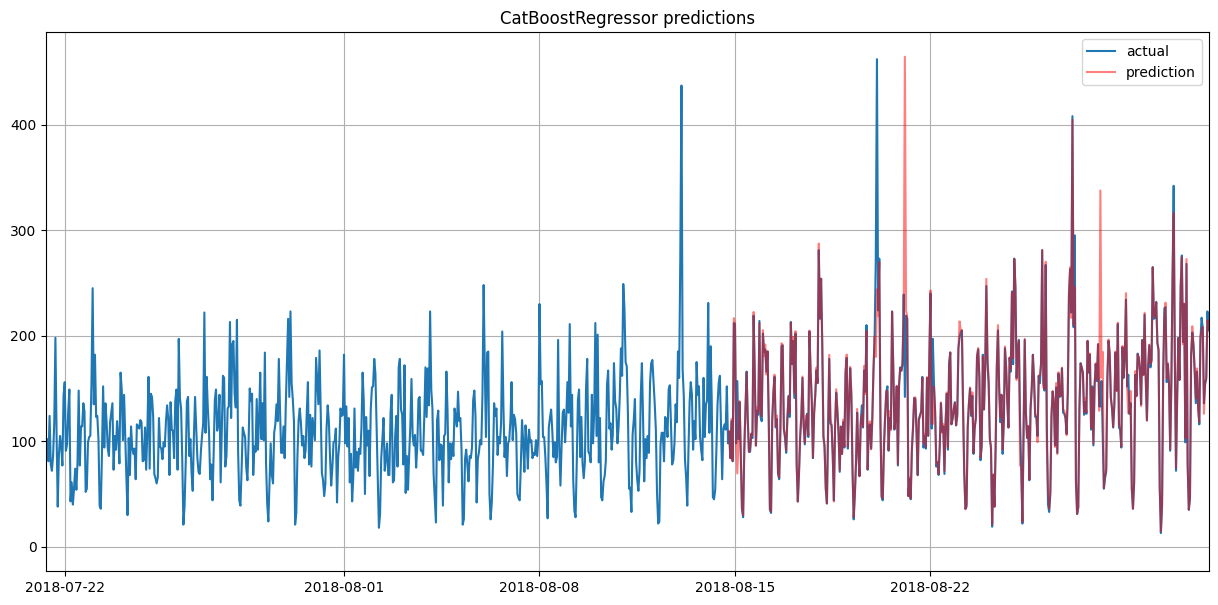

In [383]:
plt.figure(figsize=(15, 7))
plt.plot(data['num_orders'], label="actual")
plt.plot(predictions_inv['num_orders_inv'], "r", label="prediction", alpha = 0.5)
plt.legend(loc="best")
plt.title('CatBoostRegressor predictions')
plt.grid(True)
plt.xlim(data.index[-1000],data.index[-1])
#plt.xticks(data.index[-500: -1:8], rotation ='vertical')

plt.show()

## Общий вывод

<p>Обзор и предобработка: Провели ресемплинг по часу, проверили пропуски и явные дубликаты, выбросы заменили, использую метод ffill. </p>
<p>Анализ: Проанализировали тренд и сезонность ряда, рассчитали коэффициент вариации. Ряд имеет растущий тренд. Сезон - сутки. Временной ряд нестационарный. Меняется среднее значение (увеличивается) и также меняется стандартное отклонение (увеличивается в конце ряда). Подтвержденно тестом Дики-Фуллера. Уменьшили дисперсию преобразованием Бокса-Кокса. Два раза провели сезонное дифференцирование. Получили стационарный ряд. </p>

<p>Обучение: Создали новые признаки ряда - календарные признаки (month, day, dayofweek, hour), отстающие значения (lag_1, lag_2, lag_3, lag_4), скользящее среднее(rolling_mean). Для Линейной регрессии провели масштабирование численных признаков.  Обучили модели: Линейная регрессия, Случайный лес, CatBoostRegressor, LGBMRegressor и подобрали гиперпараметры. Протестировали наилучшую модель и проанализировали результаты. </p>
<p> <b> Наилучшей моделью является модель CatBoostRegressor (Количество деревьев: 58 Глубина дерева: 4 Скорость: 0.5), именно ее следует использовать заказчику. RMSE = 24.04 </b> </p>
 